# Universidad de Buenos Aires
# Aprendizaje Profundo - TP1
# Cohorte 20 - 3er bimestre 2025


Este primer TP comienza la semana de la clase 2 y la ventana de entrega estará abierta hasta las **23hs del jueves 31 de julio (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP1 EQUIVALE AL 60% DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/2UKBgNLjBZZ5XCeH9)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP1.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP1-Co20.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

# **PREGUNTA 1**

## **Comparación de Gradiente Descendente y Adam en una Función de Costo No Convexa**

En este ejercicio se compararán los optimizadores Gradiente Descendente (GD) y Adam en la minimización de una función de costo basada en una red neuronal de una sola neurona:
$$
z = w x + b
$$
Con función de activación tangente hiperbólica:

$$
\hat{y} = \tanh(z) = \tanh(w x + b)
$$

\\

Se analizará la trayectoria de aprendizaje de ambos algoritmos y se evaluará su eficiencia con diferentes tasas de aprendizaje (learning rate).

\\

La función de costo utilizada es el Error Cuadrático Medio (MSE):

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2
$$

$$
J(w, b) = \frac{1}{m} \sum_{i=1}^{m} ( \tanh(w x_i + b) - y_i )^2
$$

donde \\( w \\) y \\( b \\) son los parámetros a optimizar.

\\

Si bien es cierto, en estos experimentos estamos comparando optimizadores (GD vs Adam), y no entrenando un modelo como tal, de igual forma se necesitará una especie de dataset. Este será sintético y solo de prueba, por ende tendrán cierta libertad para elegir sus valores. Sin embargo deberán tomar en cuenta que cumpla la siguiente estructura:

`x = np.linspace(ini, fin, n)`

donde `x` es un array de una sola dimensión y con `n` cantidad de valores. Y tiene un rango de valores desde `ini` hasta `fin`. Recomiendo que sea simétrico, es decir, los mismos valores solo que con el signo cambiado, por ejemplo `ini=-3, fin=3`.

\\

Y con un target `y`:

`y = funcion_no_lineal(x) + ruido`

donde `y` es también un vector de una sola dimensión de tamaño `n` que sigue un patrón no lineal con respecto a `x` adicionando un ruido que puede ser creado con algunas de las funciones del paquete `np.random`.


### 1a) Implementación del Gradiente Descendente (1 punto)
- Implementar el algoritmo del Gradiente Descendente (GD) para minimizar \\( J(w, b) \\).
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Inicializar valores de \\( w \\) y \\( b \\) de manera aleatoria con `np.random.randn()` para cada learning rate.
- Graficar la función de Costo \\( J(w, b) \\) VS número de época

\\

El optimizador del Gradiente Descendente se debe implementar haciendo el código desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

In [4]:
from typing import Literal, Optional, Dict, List, Tuple
import numpy as np
from matplotlib import pyplot as plt

SEED = 42

In [5]:
class SimplePerceptron:
    """
    A simple implementation of a single neuron perceptron. With parametrizable
    input and one output. The activation function is the hyperbolic tangent
    function (tanh) by default.
    """
    def __init__(
        self, 
    ):
        """
        Init method for the perceptron.
        """
        np.random.seed(SEED)  # Set seed for reproducibility
        self.weight = np.random.rand(1)
        self.bias = np.random.rand(1)
        
        # Saves the weights and bias for each epoch
        self.w_b: Tuple[List[float], List[float]] = (list(), list())
        self._activation_fun = np.tanh
        self._lr: float = None

    def _reset_weights(self):
        """
        Resets the weights and bias of the perceptron to random values.
        """
        np.random.seed(SEED)
        self.weight = np.random.rand(1)
        self.bias = np.random.rand(1)
        self.w_b = (list(), list())  # Reset the history of weights and bias

    @staticmethod
    def batch_generator(X, y, batch_size=32, shuffle=False):
        n_samples = X.shape[0]
        indices = np.arange(n_samples)

        if shuffle:
            np.random.shuffle(indices)

        for start_idx in range(0, n_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            yield X[batch_indices], y[batch_indices]

    def train(
        self, 
        inputs: np.ndarray, 
        targets: np.ndarray,
        epochs: int,
        lr: float,
        optim: Optional[Literal['adam']] = None,
        batch_size: Optional[int] = None,
        checkpoint: bool = False):
        """
        Trains the perceptron using the provided inputs and targets.

        Parameters
        ----------
        inputs: np.ndarray
            Input data to perform the forward pass.
        targets: np.ndarray
            Target output.
        epochs: int
            Number of epochs.
        lr: float
            Learning rate for the training.
        optim: Optional[Literal['adam']]
            Optimization algorithm to be used. Currently only adam is supported.
            If None, no optimization is applied and the perceptron will use a
            gradient descent update.
        checkpoint: bool
            If True, retrains on top of the wheights and bias of the perceptron.
            If False, the perceptron will be re initialized with random weights
            and bias.
        
        Mutates
        -------
        self.weights: np.ndarray
            Updates the weights of the perceptron.
        self.bias: float
            Updates the bias of the perceptron.
        """
        assert inputs.shape[0] == targets.shape[0], "mismatched input and target sizes"
        
        # mse per epoch
        self.mse = list()

        # Reset weights and bias if not checkpointing
        if not checkpoint:
            self._reset_weights()

        if optim == 'adam':
            r_w, v_w = np.zeros_like(self.weight), np.zeros_like(self.weight)
            r_b, v_b = np.zeros_like(self.bias), np.zeros_like(self.bias)
            p1, p2  = 0.9, 0.999

        _batch_size = len(inputs) if batch_size is None else batch_size
        
        weighs = list()
        bias = list()

        for epoch in range(epochs):

            error = list()
            # create batches
            for x_batch, y_batch in self.batch_generator(
                X=inputs, y=targets, batch_size=_batch_size, shuffle=False):

                # Forward pass
                output = self.predict(inputs=x_batch)

                # Calculate the loss (mean squared error)
                error.append(np.mean(np.power(y_batch - output, 2)).item())
                
                # Derivative of the loss with respect to the output
                grad = -2 * (y_batch - output) * (1 - output ** 2)
                grad_w = np.mean(grad * x_batch)
                grad_b = np.mean(grad)

                if optim is None:
                    # Gradient descent update
                    self.weight -= lr * grad_w
                    self.bias -= lr * grad_b

                elif optim == 'adam':
                    # Momentum update for weights
                    v_w = p1 * v_w + (1 - p1) * grad_w
                    r_w = p2 * r_w + (1 - p2) * (grad_w ** 2)
                    # Momentum update for bias
                    v_b = p1 * v_b + (1 - p1) * grad_b
                    r_b = p2 * r_b + (1 - p2) * (grad_b ** 2)                    
                    self.weight -= lr * v_w / (np.sqrt(r_w) + 1e-8)  # Adding epsilon to avoid division by zero
                    self.bias -= lr * v_b / (np.sqrt(r_b) + 1e-8)
                
            self.mse.append(np.mean(error).item())  # Average loss for the epoch
            weighs.append(self.weight.item())
            bias.append(self.bias.item())
            print(f'Epoch {epoch + 1}/{epochs}, Avg Loss: {self.mse[-1]:.4f}')
        self.w_b = (weighs, bias)

    def predict(self, inputs: np.ndarray) -> List[float]:
        """
        Performs a forward pass through the perceptron.
        
        Parameters
        ----------
        inputs: np.ndarray
            Input data to the perceptron.
        Returns
        -------
        float
            Output of the perceptron after applying the activation function.
        """
        z = self.weight * inputs + self.bias
        return np.tanh(z)

Genero data de entrada y salida

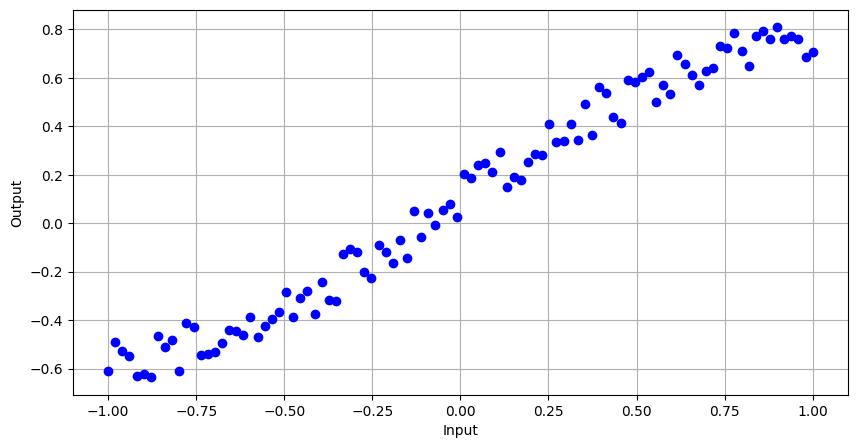

In [6]:
# for reproducibility
np.random.seed(42)

n_samples = 100
input = np.linspace(-1, 1, n_samples)
target = np.tanh(np.sin(input)) + 0.2 * np.random.rand(len(input))

plt.figure(figsize=(10, 5))
plt.plot(input, target, color='blue', marker='o', linestyle='None')
plt.title('Plot of tanh(sin(x))')
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('')
plt.grid()
plt.show()


Epoch 1/100, Avg Loss: 0.5321
Epoch 2/100, Avg Loss: 0.4743
Epoch 3/100, Avg Loss: 0.4121
Epoch 4/100, Avg Loss: 0.3479
Epoch 5/100, Avg Loss: 0.2850
Epoch 6/100, Avg Loss: 0.2268
Epoch 7/100, Avg Loss: 0.1761
Epoch 8/100, Avg Loss: 0.1344
Epoch 9/100, Avg Loss: 0.1016
Epoch 10/100, Avg Loss: 0.0767
Epoch 11/100, Avg Loss: 0.0582
Epoch 12/100, Avg Loss: 0.0448
Epoch 13/100, Avg Loss: 0.0350
Epoch 14/100, Avg Loss: 0.0280
Epoch 15/100, Avg Loss: 0.0228
Epoch 16/100, Avg Loss: 0.0191
Epoch 17/100, Avg Loss: 0.0164
Epoch 18/100, Avg Loss: 0.0143
Epoch 19/100, Avg Loss: 0.0128
Epoch 20/100, Avg Loss: 0.0116
Epoch 21/100, Avg Loss: 0.0106
Epoch 22/100, Avg Loss: 0.0099
Epoch 23/100, Avg Loss: 0.0093
Epoch 24/100, Avg Loss: 0.0088
Epoch 25/100, Avg Loss: 0.0084
Epoch 26/100, Avg Loss: 0.0080
Epoch 27/100, Avg Loss: 0.0077
Epoch 28/100, Avg Loss: 0.0075
Epoch 29/100, Avg Loss: 0.0072
Epoch 30/100, Avg Loss: 0.0070
Epoch 31/100, Avg Loss: 0.0068
Epoch 32/100, Avg Loss: 0.0066
Epoch 33/100, Avg

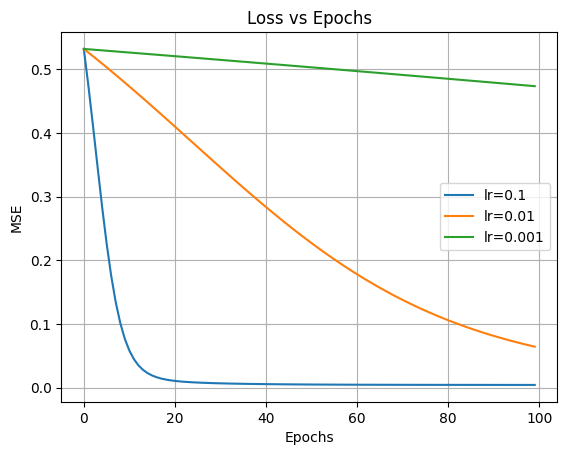

In [7]:
epochs = 100
l_rates = [0.1, 0.01, 0.001]

slp = SimplePerceptron()
preds: Dict[float, List[float]] = dict()
losses_gd: Dict[float, List[float]] = dict()
w_b_gd: Dict[float, Tuple[List[float], List[float]]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, targets=target, epochs=epochs, lr=lr, checkpoint=False)
    
    losses_gd[lr] = slp.mse.copy()  # Store the losses for each learning rate
    w_b_gd[lr] = slp.w_b  # Store the weights and bias for each learning rate 
    preds[lr] = slp.predict(inputs=input) # Store the preds for each learning rate
    
    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

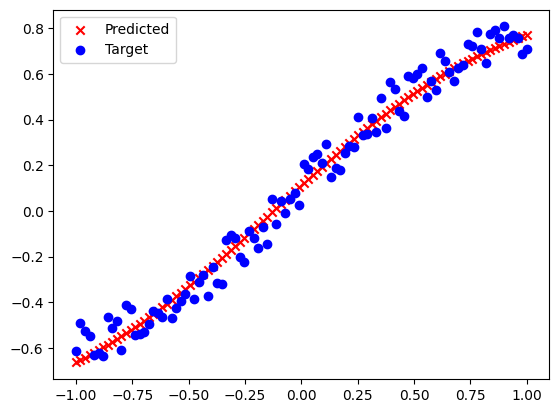

In [8]:
outputs = list()

plt.figure()
plt.scatter(input, preds[0.1], marker='x', color='red')
plt.scatter(input, target, color='blue', marker='o')
plt.legend(['Predicted', 'Target'])
plt.show()

### 1b) Implementación de Adam (1 punto)  
- Implementar el algoritmo de Adam para minimizar \\( J(w, b) \\).  
- Utilizar 100 épocas y 3 diferentes learning rates `(0.1, 0.01, 0.001)`.
- Utilizar los mismos valores de \\( w \\) y \\( b \\) que se usaron para GD para cada diferente learning rate.
- Graficar la función de Costo \\( J(w, b) \\) VS número de época
- Hacer 2 modelos, uno sin mini-batch (full-batch) y otro con mini-batch (batch size a elección de ustedes).

\\

Al igual que para GD, el optimizador Adam también se debe implementar desde cero y paso a paso. Se pueden usar librerías como `numpy`, `scipy`, `matplotlib` o similares. Pero no está permitido usar Pytorch ni TensorFlow o frameworks que ya contengan el optimizador desarrollado.

Entrenamos usando full batch:

Epoch 1/100, Avg Loss: 0.5321
Epoch 2/100, Avg Loss: 0.2115
Epoch 3/100, Avg Loss: 0.0116
Epoch 4/100, Avg Loss: 0.0760
Epoch 5/100, Avg Loss: 0.1678
Epoch 6/100, Avg Loss: 0.2110
Epoch 7/100, Avg Loss: 0.2143
Epoch 8/100, Avg Loss: 0.1985
Epoch 9/100, Avg Loss: 0.1773
Epoch 10/100, Avg Loss: 0.1573
Epoch 11/100, Avg Loss: 0.1411
Epoch 12/100, Avg Loss: 0.1296
Epoch 13/100, Avg Loss: 0.1230
Epoch 14/100, Avg Loss: 0.1213
Epoch 15/100, Avg Loss: 0.1235
Epoch 16/100, Avg Loss: 0.1276
Epoch 17/100, Avg Loss: 0.1303
Epoch 18/100, Avg Loss: 0.1270
Epoch 19/100, Avg Loss: 0.1136
Epoch 20/100, Avg Loss: 0.0892
Epoch 21/100, Avg Loss: 0.0583
Epoch 22/100, Avg Loss: 0.0296
Epoch 23/100, Avg Loss: 0.0146
Epoch 24/100, Avg Loss: 0.0228
Epoch 25/100, Avg Loss: 0.0465
Epoch 26/100, Avg Loss: 0.0526
Epoch 27/100, Avg Loss: 0.0319
Epoch 28/100, Avg Loss: 0.0164
Epoch 29/100, Avg Loss: 0.0189
Epoch 30/100, Avg Loss: 0.0226
Epoch 31/100, Avg Loss: 0.0206
Epoch 32/100, Avg Loss: 0.0184
Epoch 33/100, Avg

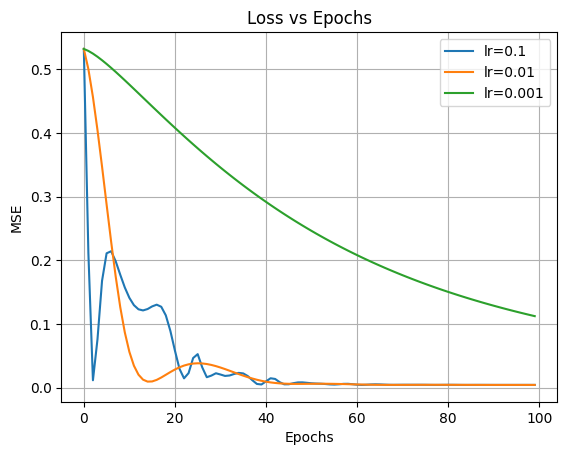

In [9]:
epochs = 100
l_rates = [0.1, 0.01, 0.001]

slp = SimplePerceptron()
losses_adam_fb: Dict[float, List[float]] = dict()
w_b_adam_fb: Dict[float, List[Tuple[float, float]]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, 
        targets=target, 
        epochs=epochs, 
        lr=lr,
        checkpoint=False, 
        optim='adam')
    losses_adam_fb[lr] = slp.mse.copy()
    w_b_adam_fb[lr] = slp.w_b

    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

Adam con minibatch de N muestras:

Epoch 1/100, Avg Loss: 0.3241
Epoch 2/100, Avg Loss: 0.4287
Epoch 3/100, Avg Loss: 0.3151
Epoch 4/100, Avg Loss: 0.2497
Epoch 5/100, Avg Loss: 0.2232
Epoch 6/100, Avg Loss: 0.2228
Epoch 7/100, Avg Loss: 0.2233
Epoch 8/100, Avg Loss: 0.2189
Epoch 9/100, Avg Loss: 0.2096
Epoch 10/100, Avg Loss: 0.1969
Epoch 11/100, Avg Loss: 0.1821
Epoch 12/100, Avg Loss: 0.1651
Epoch 13/100, Avg Loss: 0.1434
Epoch 14/100, Avg Loss: 0.1123
Epoch 15/100, Avg Loss: 0.0650
Epoch 16/100, Avg Loss: 0.0142
Epoch 17/100, Avg Loss: 0.0298
Epoch 18/100, Avg Loss: 0.0070
Epoch 19/100, Avg Loss: 0.0106
Epoch 20/100, Avg Loss: 0.0106
Epoch 21/100, Avg Loss: 0.0060
Epoch 22/100, Avg Loss: 0.0066
Epoch 23/100, Avg Loss: 0.0043
Epoch 24/100, Avg Loss: 0.0047
Epoch 25/100, Avg Loss: 0.0050
Epoch 26/100, Avg Loss: 0.0047
Epoch 27/100, Avg Loss: 0.0046
Epoch 28/100, Avg Loss: 0.0043
Epoch 29/100, Avg Loss: 0.0044
Epoch 30/100, Avg Loss: 0.0045
Epoch 31/100, Avg Loss: 0.0045
Epoch 32/100, Avg Loss: 0.0044
Epoch 33/100, Avg

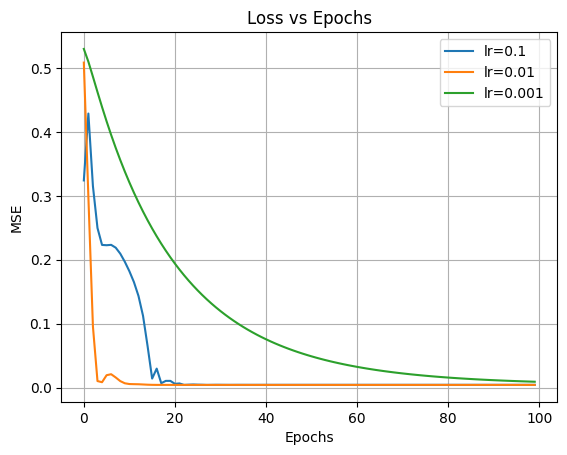

In [10]:
batch_size = 20

losses_adam_mb: Dict[float, List[float]] = dict()
w_b_adam_mb: Dict[float, List[Tuple[float, float]]] = dict()

plt.figure()
for lr in l_rates:
    slp.train(
        inputs=input, 
        targets=target, 
        epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        checkpoint=False, 
        optim='adam')
    
    # Store the loss for each learning rate
    losses_adam_mb[lr] = slp.mse.copy()
    w_b_adam_mb[lr] = slp.w_b  # Store the weights and bias for each learning rate    

    plt.plot(slp.mse, label=f'lr={lr}')
plt.title(f'Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.grid()
plt.legend()
plt.show()

### 1c) Comparativa de optimizadores (0.5 puntos)  
- Comparar el resultado y rendimiento de GD VS Adam (full-batch) VS Adam (mini-batch) para cada uno de los learning rates.
- Redactar conclusiones analíticas que resalten las diferencias entre cada optimizador.

Gradient Descent vs Adam (full-batch):

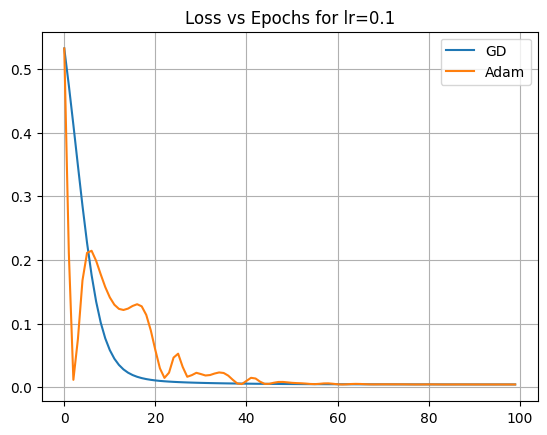

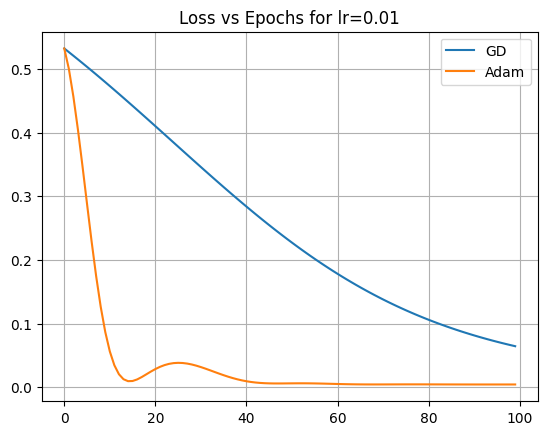

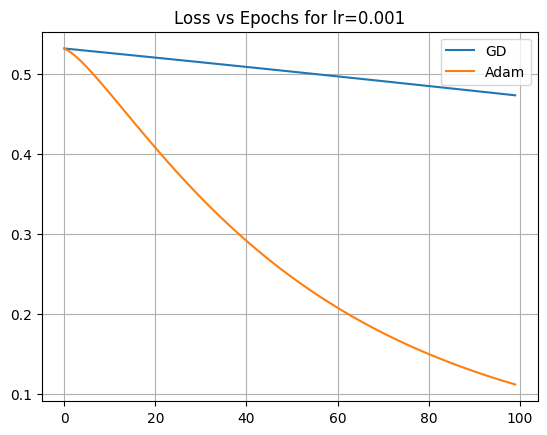

In [11]:
# reutilizamos los curvas de loss obtenidas en los items previos y graficamos
# de a pares:

for lr in l_rates:
    plt.plot(losses_gd[lr], label=f'GD lr={lr}')
    plt.plot(losses_adam_fb[lr], label=f'Adam')
    plt.title(f'Loss vs Epochs for lr={lr}')
    plt.legend(['GD', 'Adam'])
    plt.grid()
    plt.show()
    

Para valores de learning rate de 0.1 y 0.01 no se ven diferencias significativas
en el comportamiento de los optimizadores. Sin embargo, para un learning rate de 0.001, Adam alcanza un mínimo más bajo (para la misma cantidad de epochs) y más rápido que el Gradiente Descendente, lo que indica una mayor eficiencia en la convergencia. 

Gradient Descent vs Adam (mini-batch):

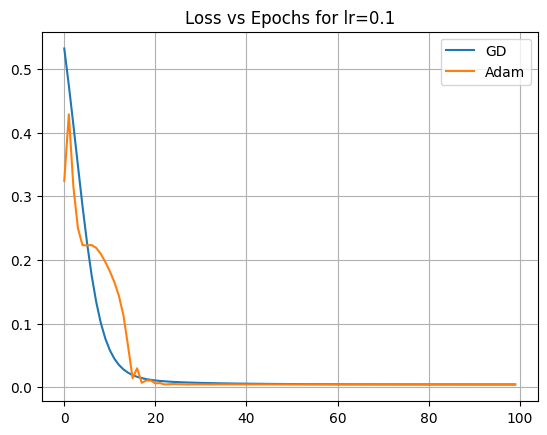

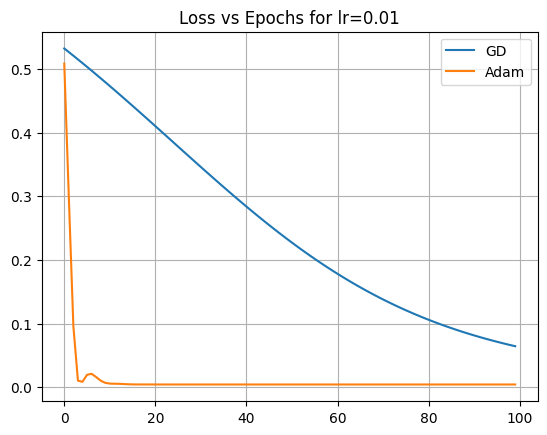

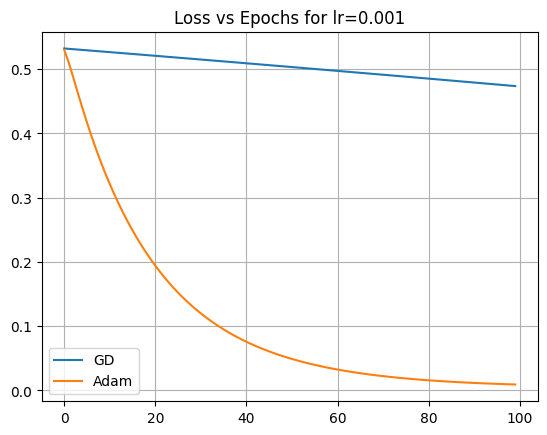

In [12]:
# ajustamos los ejes de los graficos para capturar mejor las diferencias
    
plt.figure()
plt.plot(losses_gd[0.1], label=f'GD lr={lr}')
plt.plot(losses_adam_mb[0.1], label=f'Adam')
plt.title(f'Loss vs Epochs for lr={0.1}')
plt.legend(['GD', 'Adam'])
#plt.ylim(0, 0.01)
#plt.xlim(0, 40)  
plt.grid()
plt.show()

plt.figure()
plt.plot(losses_gd[0.01], label=f'GD lr={lr}')
plt.plot(losses_adam_mb[0.01], label=f'Adam')
plt.title(f'Loss vs Epochs for lr={0.01}')
plt.legend(['GD', 'Adam'])
#plt.ylim(0, 0.02)
#plt.xlim(0, 40)  
plt.grid()
plt.show()

plt.figure()
plt.plot(losses_gd[0.001], label=f'GD lr={lr}')
plt.plot(losses_adam_mb[0.001], label=f'Adam')
plt.title(f'Loss vs Epochs for lr={0.001}')
plt.legend(['GD', 'Adam'])
#plt.ylim(0, 0.01)
# plt.xlim(0, 40)  
plt.grid()
plt.show()

Para el caso del mini-batch, se observa que Adam alcanza una loss mas alta para 
learning rates de 0.1 y 0.01, pero converge más rápido que el Gradiente Descendente. Para un learning rate de 0.001, Adam muestra una convergencia más eficiente que el Gradiente Descendente, alcanzando un mínimo más bajo en menos épocas.

### 1d) Visualización en 3D de la trayectoria de aprendizaje (0.5 puntos)
- Graficar en 3D la trayectoria del aprendizaje de los 3 optimizadores sobre la superficie de la función de costo \\( J(w, b) \\). Se debe elegir un solo learning rate.
- Comparar y redactar cómo se mueven en el espacio de parámetros y qué diferencias existen en la convergencia.
- Recomiendo utilizar `mpl_toolkits.mplot3d` y `np.meshgrid`, pero queda a su criterio la elección de funciones a usar para lograr el gráfico.

In [13]:
from mpl_toolkits.mplot3d import Axes3D

def compute_loss(w, b, X, y):
    y_pred = X * w + b
    return np.mean((y - y_pred) ** 2)

def plot_loss_surface(X, y, w_b, loss_history, title = ''):
    """
    Plots the loss surface for the given weights and bias.
    
    Parameters
    ----------
    X: np.ndarray
        Input data.
    y: np.ndarray
        Target data.
    w_b: Tuple[List[float], List[float]]
        Weights and bias history.
    """
    # create the parameters grid
    weights, bias = w_b

    w_min, w_max = -2 * max(weights), 2 * max(weights)
    b_min, b_max = -2 * max(bias), 2 * max(bias)

    w_vals = np.linspace(w_min, w_max, 100)
    b_vals = np.linspace(b_min, b_max, 100)
    W, B = np.meshgrid(w_vals, b_vals)

    Z = np.array([[compute_loss(w, b, X, y) for w in w_vals] for b in b_vals])

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(weights, bias, loss_history, color='red', marker='o', label='Training trajectory', markersize=1)
    # Plot loss surface
    ax.plot_surface(W, B, Z, cmap='viridis', alpha=0.7)
    ax.set_xlabel('Weights')
    ax.set_ylabel('Bias')
    ax.set_zlabel('Loss')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

Como la funcion costo toma valores muy pequeños durante el entrenamiento se grafica solo una porcion de la superficie para que se pueda ver la trayectoria de los optimizadores.

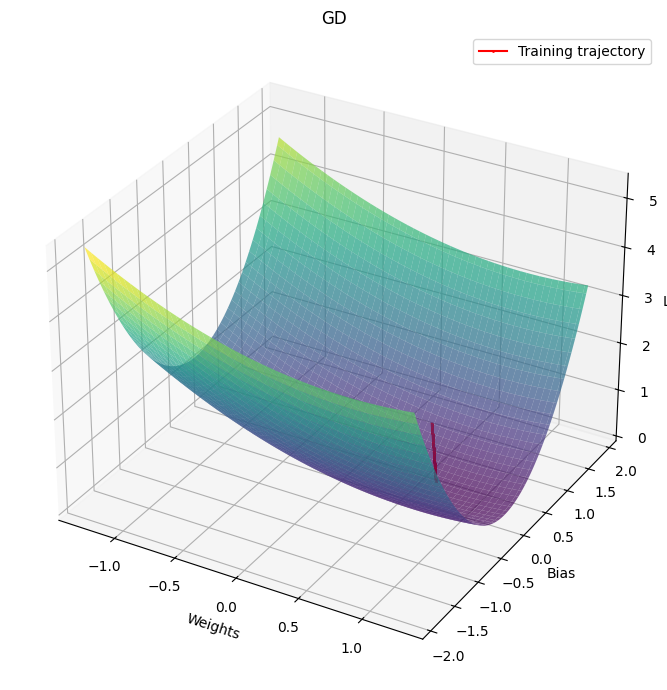

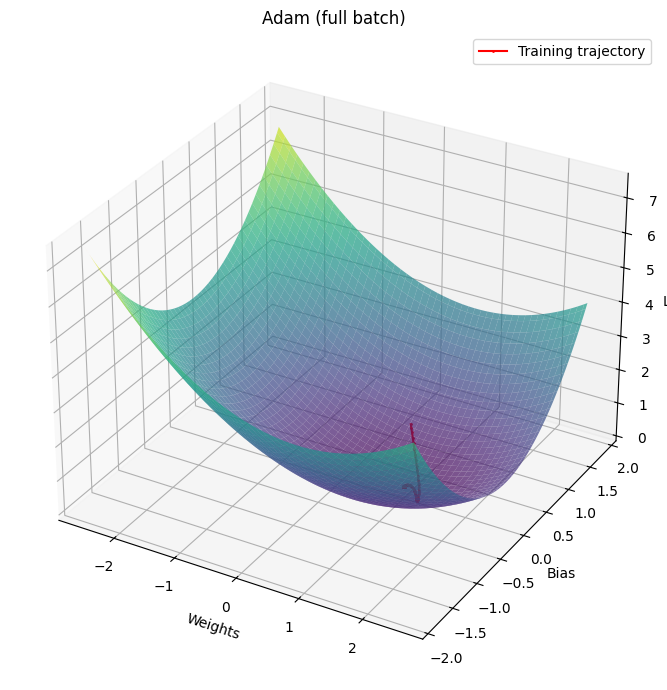

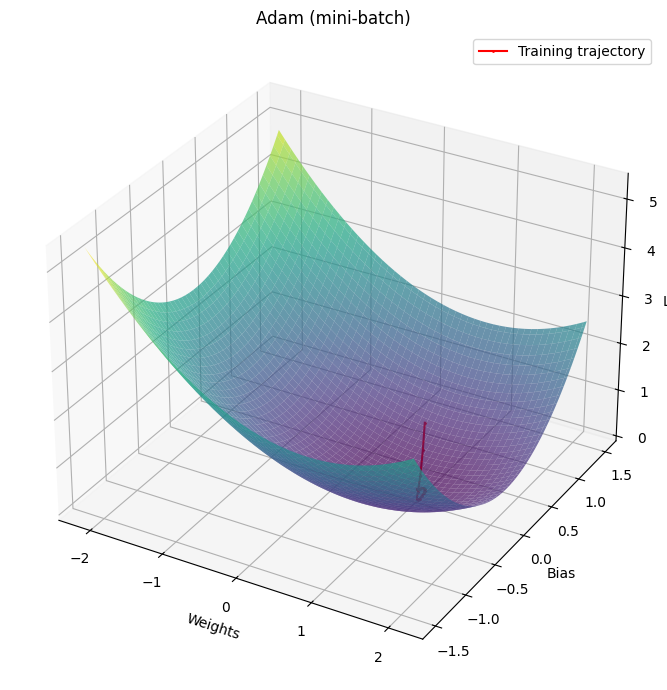

In [14]:
# descomentar para visualizar en ventana externa
#%matplotlib qt 

selected_lr = 0.01

for title, wb, losses in zip(
    ['GD', 'Adam (full batch)', 'Adam (mini-batch)'],
    [w_b_gd[selected_lr], w_b_adam_fb[selected_lr], w_b_adam_mb[selected_lr]],
    [losses_gd[selected_lr], losses_adam_fb[selected_lr], losses_adam_mb[selected_lr]]):

    plot_loss_surface(input, target, wb, losses, title=title)

Los graficos observados son consistentes con los resultados que se muestran en las gráficas de la función de costo. Lo cual tiene sentido ya que representan los mismos numeros en un espacio de mayor dimensionalidad. En el caso de Adam la convergencia se logra mas rapido para minimos mas bajos que con gradient descend pero con ligeras oscilaciones, gradient descent es mas suave pero tarda mas en alcanzar valores minimos. El mini-batch de Adam también muestra una trayectoria más rápida, pero con una convergencia menos estable.

# **PREGUNTA 2**

Descargar el dataset del siguiente link: https://drive.google.com/file/d/147YyKAiQhJhZV9tHAkrgcTzvRgmwB-OX/view?usp=sharing.

El dataset consiste en compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones, compuestas por un cliente y el producto que adquirió.


### 2a) EDA y preparación del dataset (2.5 puntos)
Realizar el análisis exploratorio del dataset (EDA) con las herramientas vistas en materias anteriores. Pre-procesar y transformar las variables que sean necesarias, analizar qué columnas se deben dropear, cuáles vale la pena hacer un tratamiento de valores nulos, si se debe usar label encoding, one-hot encoding o mapping encoding, explicar los criterios utilizados y analizar las distribuciones.

Vamos a tratar este problema como una clasificación donde queremos averiguar si el cliente pertenece a un segmento: "Casual" (gasta menos de 3000), "Gama media" (gasta entre 3000 y 8000), "Gama alta" (gasta entre 8000 y 18000) o a "Premium" (gasta más de 18000), según el producto que adquirió.

Redactar las conclusiones preliminares que pueden notar de las columnas y justificar el porqué de cada encoding aplicado.

**IMPORTANTE: Luego de asignar los segmentos, no se olviden de eliminar la columna "Purchase".**

In [15]:
import pandas as pd

DATA_PATH = './dataset_compras.csv'
# Load the dataset
df = pd.read_csv(DATA_PATH)

df.head()

,User_ID,Product_ID,Age,Gender,Marital_Status,City_Category,Stay_In_Current_City_Years,Product_Category,Product_Subcategory_1,Product_Subcategory_2,Purchase
0,1044096,P00017122,46-50,F,1,B,1,10,45.0,NaN,1810
1,1071818,P00074517,36-45,M,0,A,3,11,27.0,NaN,12351
2,1022986,P00013694,36-45,M,1,A,5+,4,28.0,NaN,127
3,1094684,P00049122,36-45,M,1,A,1,16,9.0,8.0,2214
4,1004157,P00006469,46-50,M,1,A,5+,3,NaN,NaN,7142


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182721 entries, 0 to 182720
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     182721 non-null  int64  
 1   Product_ID                  182721 non-null  object 
 2   Age                         182721 non-null  object 
 3   Gender                      182721 non-null  object 
 4   Marital_Status              182721 non-null  int64  
 5   City_Category               182721 non-null  object 
 6   Stay_In_Current_City_Years  182721 non-null  object 
 7   Product_Category            182721 non-null  int64  
 8   Product_Subcategory_1       140903 non-null  float64
 9   Product_Subcategory_2       77461 non-null   float64
 10  Purchase                    182721 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 15.3+ MB


Cantidad de datos faltantes por columna:

In [17]:
print(df.isnull().sum())

User_ID                            0
Product_ID                         0
Age                                0
Gender                             0
Marital_Status                     0
City_Category                      0
Stay_In_Current_City_Years         0
Product_Category                   0
Product_Subcategory_1          41818
Product_Subcategory_2         105260
Purchase                           0
dtype: int64


Filtrado del dataset:

Vemos que el dataset tiene 182721 columnas. La columna `Product_Subcategory_2` contiene 105260 valores nulos, lo que significa que mas del 57% de sus filas tienen datos faltantes. Al tratarse de un identificador de producto no es una informacion que se pueda estimar a partir de datos existentes, por lo tanto, se decide eliminar esta columna. 

Para el caso de la columna `Product_Subcategory_1`, que tiene 41818 valores nulos, se decide eliminarla ya que tambien tienen un 22% de datos faltantes y se espera que el modelo pueda aprender y generalizar a partir de la columna `Product_Category` que no posee datos faltantes.

Se asume que la columna `User_ID` es un identificador aleatorio único de cada usuario y no tendria mucho sentido considerarla para el entrenamiento ya que al realizar clasificacion en datos de produccion, por fuera del dataset, los ids serian diferentes y su valor no tendria relacion con la compra realizada.

In [18]:
df.drop(
    columns=['Product_Subcategory_2', 
             'Product_Subcategory_1', 
             'User_ID',
             'Product_ID'], inplace=True)

In [19]:
# Iterate over columns and print unique values for each
for col in df.columns:
    print(f"{col}: {len(df[col].unique())} unique values")

Age: 7 unique values
Gender: 2 unique values
Marital_Status: 2 unique values
City_Category: 3 unique values
Stay_In_Current_City_Years: 5 unique values
Product_Category: 20 unique values
Purchase: 1833 unique values


Transformamos la columna target `Purchase` en segmentos de clientes, y las columnas `Product_category`, `Gender`, `Stay_In_Current_City_Years`, `City_Category` las transformamos a one-hot encoding.

In [20]:
# Assign segments based on the value of 'Purchase'
def assign_segment(purchase):
    if purchase < 3000:
        return 0
    elif 3000 <= purchase < 8000:
        return 1
    elif 8000 <= purchase < 18000:
        return 3
    else:  # purchase >= 18000
        return 4

target_df = df['Purchase'].apply(assign_segment)
df.drop(columns=['Purchase'], inplace=True)

Aplicamos one-hot encoding a todas las columnas categóricas:


In [21]:
df = pd.get_dummies(df, columns=df.columns, drop_first=True)

# transformo el target, drop_first=False para mantener todas las columnas
# ya que va a ser el target de la red neuronal
target_df = target_df.to_frame(name='target')
target_df_cat = pd.get_dummies(target_df, columns=target_df.columns, drop_first=False)


In [22]:
# guardo el dataset con variables categóricas transformadas
df = pd.concat([df, target_df_cat], axis=1)
df.to_csv('dataset_compras_one_hot.csv', index=False)
df.head()

,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Gender_M,Marital_Status_1,City_Category_B,City_Category_C,...,Product_Category_15,Product_Category_16,Product_Category_17,Product_Category_18,Product_Category_19,Product_Category_20,target_0,target_1,target_3,target_4
0,False,False,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,True,False,False,False,True,True,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,True,False,False,False,True,True,False,False,...,False,True,False,False,False,False,True,False,False,False
4,False,False,False,True,False,False,True,True,False,False,...,False,False,False,False,False,False,False,True,False,False


In [23]:
import pandas as pd

df = pd.read_csv('dataset_compras_one_hot.csv')

target_cols = [col for col in df.columns if col.startswith('target_')]
y = df[target_cols].to_numpy()

print(y[0].shape)

(4,)


### 2b) Modelo de deep leaning sin embeddings (1.5 puntos)
Entrenar un modelo de deep learning usando Pytorch que no utilice embeddings, **descartando el `product_id` y `user_id`**. Graficar las evoluciones por época de la función de costo y de métricas como el accuracy y el f1 score para train y validation. Mostrar una matriz de confusión absoluta y otra normalizada por fila. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos.

Pueden usarse herramientas de regularización y prueba de hiperpametros para conseguir mejores resultados.

Un resultado aceptable sería al menos un 77% de accuracy y f1 score para el set de validation.

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

In [25]:
class MyDataset(Dataset):

  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [26]:
import pandas as pd
import numpy as np

df = pd.read_csv('dataset_compras_one_hot.csv')

target_cols = [col for col in df.columns if col.startswith('target_')]

target = df[target_cols].to_numpy().astype(np.float32)
features = df.drop(columns=target_cols).to_numpy().astype(np.float32)   


In [27]:

dataset = MyDataset(x=features, y=target)
# split in val and train
val_perc = 0.2
train_data, val_data = torch.utils.data.random_split(
    dataset, [1 - val_perc, val_perc])

print(f'Train samples: {len(train_data)}\nTest samples: {len(val_data)}')

Train samples: 146177
Test samples: 36544


In [28]:
# evaluation method
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(model, data_loader, device):
    """
    computes accuracy ad F1 score for the model on the given data loader.
    """

    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Get predicted class (argmax over output probabilities)
            _, preds = torch.max(outputs, dim=1)
            
            # convert target to index
            label_classes = torch.argmax(labels, dim=1)

            # Store predictions and true labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label_classes.cpu().numpy())

    # Compute accuracy and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Use 'weighted' for multi-class F1

    return accuracy, f1

Definimos un modelo para usar de baseline sin embeddings, con una salida de 4 clases, una para cada segmento de cliente.

In [29]:
from torch import nn
from typing import List, Literal, Union



# Arquitectura del modelo sin embeddings
class BaseNet(torch.nn.Module):

  def __init__(
      self, 
      input_features: int = 36,
      dense_layers: List[int] = [50],  # List of layer sizes 
      n_classes: int = 4,
      dropout_rates: Union[float, List[float]] = 0.1,
      activation: Literal['relu', 'gelu', 'leaky_relu', 'selu', 'silu'] = "gelu",):
    # Defino la arquitectura de la red
    super().__init__()
    
    self.input_dim = input_features
    in_features = self.input_dim

    self.activation = self._get_activation(activation)
    # Process dropout rates
    if isinstance(dropout_rates, float):
      self.dropout_rates = [dropout_rates] * len(dense_layers)
    else:
      if len(dropout_rates) != len(dense_layers):
        raise ValueError("dropout_rates must match length of dense_layers")
      self.dropout_rates = dropout_rates

    # Create dense blocks
    self.dense_blocks = nn.ModuleList()
    for i, out_features in enumerate(dense_layers):
      block = nn.ModuleDict()
            
      # Linear layer
      block['linear'] = nn.Linear(in_features, out_features)

            
      # Dropout
      block['dropout'] = nn.Dropout(self.dropout_rates[i])   
      self.dense_blocks.append(block)
      in_features = out_features
        
    # Final output layer
    self.output_layer = nn.Linear(in_features, n_classes)

  def _get_activation(self, activation: str) -> nn.Module:
    activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'leaky_relu': nn.LeakyReLU(),
            'selu': nn.SELU(),
            'silu': nn.SiLU()
        }
    return activations.get(activation.lower(), nn.GELU())

  def forward(self, x):
    # Process through dense blocks
    for block in self.dense_blocks:
      x = block['linear'](x)
            
      if 'norm' in block:
        x = block['norm'](x)          
      x = self.activation(x)
      x = block['dropout'](x)
        
    # Final output
    x = self.output_layer(x)
    return x

In [30]:
model = BaseNet(
    input_features=features.shape[1], 
    n_classes=target.shape[1],
    dropout_rates=[0.2, 0.1, 0.1],
    dense_layers=[128, 64, 32])
print(summary(model, input_size=(1, features.shape[1])))

Layer (type:depth-idx)                   Output Shape              Param #
BaseNet                                  [1, 4]                    --
├─ModuleList: 1-7                        --                        (recursive)
│    └─ModuleDict: 2-2                   --                        (recursive)
│    │    └─Linear: 3-1                  [1, 128]                  4,352
├─GELU: 1-2                              [1, 128]                  --
├─ModuleList: 1-7                        --                        (recursive)
│    └─ModuleDict: 2-2                   --                        (recursive)
│    │    └─Dropout: 3-2                 [1, 128]                  --
│    └─ModuleDict: 2-4                   --                        (recursive)
│    │    └─Linear: 3-3                  [1, 64]                   8,256
├─GELU: 1-4                              [1, 64]                   --
├─ModuleList: 1-7                        --                        (recursive)
│    └─ModuleDict: 2-4   

Training loop

In [32]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# device = "mps" if torch.backends.mps.is_available() else "cpu"

model.to(device)
print(f'running on device: {device}')

# Loss & optimizer
loss = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3)

EPOCHS = 100
BATCH_SIZE = 64

# Creamos un DataLoader para iterar sobre el dataset
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

running on device: cuda:0


In [33]:
from tqdm import tqdm

train_loss_avg = list()
validation_loss_avg = list()

train_acc_list = list()
train_f1_list = list()
val_acc_list = list()
val_f1_list = list()

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    train_loss_avg.append(0)
    num_batches = 0
    
    for inputs, targets in tqdm(train_loader):

        inputs, targets = inputs.to(device), targets.to(device)  # Move to device

        optimizer.zero_grad()  # Clear gradients
        outputs = model(inputs)  # Forward pass
        loss_value = loss(outputs, targets)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        train_loss_avg[-1] += loss_value.item()
        num_batches += 1   
    train_loss_avg[-1] /= num_batches

    # metrics computation

    # train
    train_acc, train_f1 = compute_metrics(model, train_loader, device)
    # validation
    val_acc, val_f1 = compute_metrics(
        model, DataLoader(val_data, batch_size=BATCH_SIZE), device)
    
    # append per epoch data for plotting
    train_acc_list.append(train_acc)
    train_f1_list.append(train_f1)
    val_acc_list.append(val_acc)
    val_f1_list.append(val_f1)

    # Validation loss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients for validation
        num_batches = 0
        validation_loss_avg.append(0)

        for inputs, targets in DataLoader(val_data, batch_size=BATCH_SIZE):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            validation_loss_avg[-1] += loss(outputs, targets).item()
            num_batches += 1
        validation_loss_avg[-1] /= num_batches
    print(f"Epoch {epoch+1}, Train loss: {train_loss_avg[-1]:.4f} Val Loss: {validation_loss_avg[-1]:.4f}")
    print(f"Train Acc: {train_acc:.4f} Train F1: {train_f1:.4f} Val Acc: {val_acc:.4f} Val F1: {val_f1:.4f}")

100%|██████████| 2285/2285 [00:02<00:00, 810.42it/s]


Epoch 1, Train loss: 0.0820 Val Loss: 0.0772
Train Acc: 0.7615 Train F1: 0.7553 Val Acc: 0.7627 Val F1: 0.7566


100%|██████████| 2285/2285 [00:02<00:00, 853.07it/s]


Epoch 2, Train loss: 0.0795 Val Loss: 0.0767
Train Acc: 0.7577 Train F1: 0.7519 Val Acc: 0.7586 Val F1: 0.7530


100%|██████████| 2285/2285 [00:02<00:00, 855.20it/s]


Epoch 3, Train loss: 0.0793 Val Loss: 0.0764
Train Acc: 0.7615 Train F1: 0.7550 Val Acc: 0.7623 Val F1: 0.7559


100%|██████████| 2285/2285 [00:02<00:00, 862.47it/s]


Epoch 4, Train loss: 0.0792 Val Loss: 0.0776
Train Acc: 0.7606 Train F1: 0.7552 Val Acc: 0.7618 Val F1: 0.7566


100%|██████████| 2285/2285 [00:02<00:00, 846.55it/s]


Epoch 5, Train loss: 0.0791 Val Loss: 0.0761
Train Acc: 0.7617 Train F1: 0.7548 Val Acc: 0.7630 Val F1: 0.7562


100%|██████████| 2285/2285 [00:02<00:00, 849.17it/s]


Epoch 6, Train loss: 0.0789 Val Loss: 0.0768
Train Acc: 0.7623 Train F1: 0.7558 Val Acc: 0.7632 Val F1: 0.7568


100%|██████████| 2285/2285 [00:02<00:00, 881.84it/s]


Epoch 7, Train loss: 0.0788 Val Loss: 0.0772
Train Acc: 0.7614 Train F1: 0.7557 Val Acc: 0.7628 Val F1: 0.7572


100%|██████████| 2285/2285 [00:02<00:00, 853.00it/s]


Epoch 8, Train loss: 0.0787 Val Loss: 0.0767
Train Acc: 0.7611 Train F1: 0.7554 Val Acc: 0.7620 Val F1: 0.7565


100%|██████████| 2285/2285 [00:02<00:00, 854.46it/s]


Epoch 9, Train loss: 0.0785 Val Loss: 0.0767
Train Acc: 0.7599 Train F1: 0.7545 Val Acc: 0.7608 Val F1: 0.7557


100%|██████████| 2285/2285 [00:02<00:00, 853.31it/s]


Epoch 10, Train loss: 0.0783 Val Loss: 0.0763
Train Acc: 0.7631 Train F1: 0.7566 Val Acc: 0.7639 Val F1: 0.7576


100%|██████████| 2285/2285 [00:02<00:00, 851.22it/s]


Epoch 11, Train loss: 0.0783 Val Loss: 0.0767
Train Acc: 0.7603 Train F1: 0.7540 Val Acc: 0.7613 Val F1: 0.7551


100%|██████████| 2285/2285 [00:02<00:00, 812.32it/s]


Epoch 12, Train loss: 0.0782 Val Loss: 0.0762
Train Acc: 0.7619 Train F1: 0.7561 Val Acc: 0.7632 Val F1: 0.7576


100%|██████████| 2285/2285 [00:02<00:00, 818.40it/s]


Epoch 13, Train loss: 0.0782 Val Loss: 0.0761
Train Acc: 0.7608 Train F1: 0.7544 Val Acc: 0.7622 Val F1: 0.7559


100%|██████████| 2285/2285 [00:02<00:00, 783.96it/s]


Epoch 14, Train loss: 0.0780 Val Loss: 0.0764
Train Acc: 0.7616 Train F1: 0.7559 Val Acc: 0.7624 Val F1: 0.7569


100%|██████████| 2285/2285 [00:02<00:00, 799.00it/s]


Epoch 15, Train loss: 0.0780 Val Loss: 0.0773
Train Acc: 0.7585 Train F1: 0.7524 Val Acc: 0.7589 Val F1: 0.7532


100%|██████████| 2285/2285 [00:02<00:00, 802.69it/s]


Epoch 16, Train loss: 0.0779 Val Loss: 0.0764
Train Acc: 0.7549 Train F1: 0.7434 Val Acc: 0.7577 Val F1: 0.7465


100%|██████████| 2285/2285 [00:02<00:00, 852.61it/s]


Epoch 17, Train loss: 0.0779 Val Loss: 0.0765
Train Acc: 0.7614 Train F1: 0.7558 Val Acc: 0.7624 Val F1: 0.7570


100%|██████████| 2285/2285 [00:02<00:00, 904.77it/s]


Epoch 18, Train loss: 0.0780 Val Loss: 0.0763
Train Acc: 0.7636 Train F1: 0.7569 Val Acc: 0.7641 Val F1: 0.7577


100%|██████████| 2285/2285 [00:02<00:00, 869.19it/s]


Epoch 19, Train loss: 0.0780 Val Loss: 0.0762
Train Acc: 0.7615 Train F1: 0.7546 Val Acc: 0.7628 Val F1: 0.7560


100%|██████████| 2285/2285 [00:02<00:00, 872.89it/s]


Epoch 20, Train loss: 0.0779 Val Loss: 0.0764
Train Acc: 0.7627 Train F1: 0.7561 Val Acc: 0.7639 Val F1: 0.7574


100%|██████████| 2285/2285 [00:02<00:00, 878.52it/s]


Epoch 21, Train loss: 0.0779 Val Loss: 0.0764
Train Acc: 0.7633 Train F1: 0.7567 Val Acc: 0.7646 Val F1: 0.7582


100%|██████████| 2285/2285 [00:02<00:00, 842.10it/s]


Epoch 22, Train loss: 0.0778 Val Loss: 0.0759
Train Acc: 0.7630 Train F1: 0.7565 Val Acc: 0.7634 Val F1: 0.7571


100%|██████████| 2285/2285 [00:02<00:00, 793.78it/s]


Epoch 23, Train loss: 0.0780 Val Loss: 0.0770
Train Acc: 0.7633 Train F1: 0.7567 Val Acc: 0.7640 Val F1: 0.7575


100%|██████████| 2285/2285 [00:02<00:00, 866.55it/s]


Epoch 24, Train loss: 0.0780 Val Loss: 0.0762
Train Acc: 0.7616 Train F1: 0.7559 Val Acc: 0.7624 Val F1: 0.7569


100%|██████████| 2285/2285 [00:02<00:00, 782.61it/s]


Epoch 25, Train loss: 0.0779 Val Loss: 0.0769
Train Acc: 0.7634 Train F1: 0.7568 Val Acc: 0.7640 Val F1: 0.7575


100%|██████████| 2285/2285 [00:02<00:00, 809.65it/s]


Epoch 26, Train loss: 0.0778 Val Loss: 0.0759
Train Acc: 0.7635 Train F1: 0.7571 Val Acc: 0.7644 Val F1: 0.7582


100%|██████████| 2285/2285 [00:02<00:00, 888.58it/s]


Epoch 27, Train loss: 0.0779 Val Loss: 0.0765
Train Acc: 0.7633 Train F1: 0.7567 Val Acc: 0.7644 Val F1: 0.7581


100%|██████████| 2285/2285 [00:02<00:00, 818.50it/s]


Epoch 28, Train loss: 0.0778 Val Loss: 0.0759
Train Acc: 0.7632 Train F1: 0.7568 Val Acc: 0.7642 Val F1: 0.7580


100%|██████████| 2285/2285 [00:02<00:00, 765.22it/s]


Epoch 29, Train loss: 0.0779 Val Loss: 0.0760
Train Acc: 0.7638 Train F1: 0.7573 Val Acc: 0.7651 Val F1: 0.7587


100%|██████████| 2285/2285 [00:03<00:00, 710.01it/s]


Epoch 30, Train loss: 0.0779 Val Loss: 0.0762
Train Acc: 0.7638 Train F1: 0.7572 Val Acc: 0.7646 Val F1: 0.7582


100%|██████████| 2285/2285 [00:02<00:00, 829.65it/s]


Epoch 31, Train loss: 0.0780 Val Loss: 0.0762
Train Acc: 0.7634 Train F1: 0.7570 Val Acc: 0.7641 Val F1: 0.7579


100%|██████████| 2285/2285 [00:02<00:00, 856.65it/s]


Epoch 32, Train loss: 0.0778 Val Loss: 0.0763
Train Acc: 0.7623 Train F1: 0.7563 Val Acc: 0.7634 Val F1: 0.7577


100%|██████████| 2285/2285 [00:02<00:00, 834.88it/s]


Epoch 33, Train loss: 0.0778 Val Loss: 0.0763
Train Acc: 0.7580 Train F1: 0.7548 Val Acc: 0.7568 Val F1: 0.7537


100%|██████████| 2285/2285 [00:02<00:00, 887.66it/s]


Epoch 34, Train loss: 0.0781 Val Loss: 0.0759
Train Acc: 0.7634 Train F1: 0.7570 Val Acc: 0.7643 Val F1: 0.7581


100%|██████████| 2285/2285 [00:02<00:00, 900.69it/s]


Epoch 35, Train loss: 0.0777 Val Loss: 0.0761
Train Acc: 0.7634 Train F1: 0.7571 Val Acc: 0.7644 Val F1: 0.7582


100%|██████████| 2285/2285 [00:02<00:00, 892.55it/s]


Epoch 36, Train loss: 0.0777 Val Loss: 0.0759
Train Acc: 0.7639 Train F1: 0.7573 Val Acc: 0.7653 Val F1: 0.7588


100%|██████████| 2285/2285 [00:02<00:00, 815.11it/s]


Epoch 37, Train loss: 0.0782 Val Loss: 0.0763
Train Acc: 0.7627 Train F1: 0.7566 Val Acc: 0.7644 Val F1: 0.7583


100%|██████████| 2285/2285 [00:02<00:00, 869.74it/s]


Epoch 38, Train loss: 0.0778 Val Loss: 0.0758
Train Acc: 0.7636 Train F1: 0.7570 Val Acc: 0.7648 Val F1: 0.7584


100%|██████████| 2285/2285 [00:02<00:00, 868.31it/s]


Epoch 39, Train loss: 0.0779 Val Loss: 0.0763
Train Acc: 0.7631 Train F1: 0.7565 Val Acc: 0.7637 Val F1: 0.7574


100%|██████████| 2285/2285 [00:02<00:00, 899.15it/s]


Epoch 40, Train loss: 0.0778 Val Loss: 0.0759
Train Acc: 0.7628 Train F1: 0.7563 Val Acc: 0.7636 Val F1: 0.7572


100%|██████████| 2285/2285 [00:02<00:00, 874.57it/s]


Epoch 41, Train loss: 0.0777 Val Loss: 0.0768
Train Acc: 0.7402 Train F1: 0.7347 Val Acc: 0.7405 Val F1: 0.7347


100%|██████████| 2285/2285 [00:02<00:00, 899.53it/s]


Epoch 42, Train loss: 0.0778 Val Loss: 0.0758
Train Acc: 0.7636 Train F1: 0.7572 Val Acc: 0.7647 Val F1: 0.7584


100%|██████████| 2285/2285 [00:02<00:00, 831.23it/s]


Epoch 43, Train loss: 0.0777 Val Loss: 0.0763
Train Acc: 0.7633 Train F1: 0.7566 Val Acc: 0.7643 Val F1: 0.7578


100%|██████████| 2285/2285 [00:02<00:00, 849.34it/s]


Epoch 44, Train loss: 0.0778 Val Loss: 0.0759
Train Acc: 0.7631 Train F1: 0.7564 Val Acc: 0.7652 Val F1: 0.7585


100%|██████████| 2285/2285 [00:02<00:00, 850.19it/s]


Epoch 45, Train loss: 0.0779 Val Loss: 0.0764
Train Acc: 0.7621 Train F1: 0.7561 Val Acc: 0.7628 Val F1: 0.7571


100%|██████████| 2285/2285 [00:02<00:00, 864.64it/s]


Epoch 46, Train loss: 0.0777 Val Loss: 0.0763
Train Acc: 0.7638 Train F1: 0.7571 Val Acc: 0.7647 Val F1: 0.7583


100%|██████████| 2285/2285 [00:02<00:00, 873.02it/s]


Epoch 47, Train loss: 0.0782 Val Loss: 0.0759
Train Acc: 0.7638 Train F1: 0.7572 Val Acc: 0.7651 Val F1: 0.7587


100%|██████████| 2285/2285 [00:02<00:00, 875.31it/s]


Epoch 48, Train loss: 0.0784 Val Loss: 0.0761
Train Acc: 0.7631 Train F1: 0.7566 Val Acc: 0.7638 Val F1: 0.7575


100%|██████████| 2285/2285 [00:02<00:00, 868.33it/s]


Epoch 49, Train loss: 0.0777 Val Loss: 0.0763
Train Acc: 0.7612 Train F1: 0.7556 Val Acc: 0.7621 Val F1: 0.7568


100%|██████████| 2285/2285 [00:02<00:00, 862.79it/s]


Epoch 50, Train loss: 0.0776 Val Loss: 0.0760
Train Acc: 0.7569 Train F1: 0.7450 Val Acc: 0.7596 Val F1: 0.7481


100%|██████████| 2285/2285 [00:02<00:00, 813.52it/s]


Epoch 51, Train loss: 0.0779 Val Loss: 0.0758
Train Acc: 0.7635 Train F1: 0.7571 Val Acc: 0.7643 Val F1: 0.7581


100%|██████████| 2285/2285 [00:02<00:00, 853.73it/s]


Epoch 52, Train loss: 0.0777 Val Loss: 0.0760
Train Acc: 0.7614 Train F1: 0.7558 Val Acc: 0.7624 Val F1: 0.7570


100%|██████████| 2285/2285 [00:02<00:00, 858.78it/s]


Epoch 53, Train loss: 0.0779 Val Loss: 0.0760
Train Acc: 0.7632 Train F1: 0.7566 Val Acc: 0.7640 Val F1: 0.7575


100%|██████████| 2285/2285 [00:02<00:00, 844.04it/s]


Epoch 54, Train loss: 0.0777 Val Loss: 0.0759
Train Acc: 0.7624 Train F1: 0.7564 Val Acc: 0.7638 Val F1: 0.7579


100%|██████████| 2285/2285 [00:02<00:00, 861.83it/s]


Epoch 55, Train loss: 0.0778 Val Loss: 0.0761
Train Acc: 0.7628 Train F1: 0.7562 Val Acc: 0.7637 Val F1: 0.7572


100%|██████████| 2285/2285 [00:02<00:00, 832.45it/s]


Epoch 56, Train loss: 0.0776 Val Loss: 0.0759
Train Acc: 0.7621 Train F1: 0.7562 Val Acc: 0.7631 Val F1: 0.7574


100%|██████████| 2285/2285 [00:02<00:00, 844.85it/s]


Epoch 57, Train loss: 0.0786 Val Loss: 0.0768
Train Acc: 0.7590 Train F1: 0.7512 Val Acc: 0.7609 Val F1: 0.7531


100%|██████████| 2285/2285 [00:02<00:00, 845.77it/s]


Epoch 58, Train loss: 0.0783 Val Loss: 0.0761
Train Acc: 0.7633 Train F1: 0.7567 Val Acc: 0.7647 Val F1: 0.7582


100%|██████████| 2285/2285 [00:02<00:00, 842.61it/s]


Epoch 59, Train loss: 0.0777 Val Loss: 0.0759
Train Acc: 0.7635 Train F1: 0.7570 Val Acc: 0.7647 Val F1: 0.7583


100%|██████████| 2285/2285 [00:02<00:00, 860.52it/s]


Epoch 60, Train loss: 0.0779 Val Loss: 0.0761
Train Acc: 0.7634 Train F1: 0.7571 Val Acc: 0.7644 Val F1: 0.7582


100%|██████████| 2285/2285 [00:02<00:00, 842.99it/s]


Epoch 61, Train loss: 0.0776 Val Loss: 0.0760
Train Acc: 0.7634 Train F1: 0.7567 Val Acc: 0.7647 Val F1: 0.7581


100%|██████████| 2285/2285 [00:02<00:00, 851.26it/s]


Epoch 62, Train loss: 0.0782 Val Loss: 0.0761
Train Acc: 0.7633 Train F1: 0.7570 Val Acc: 0.7644 Val F1: 0.7582


100%|██████████| 2285/2285 [00:02<00:00, 876.13it/s]


Epoch 63, Train loss: 0.0776 Val Loss: 0.0758
Train Acc: 0.7637 Train F1: 0.7572 Val Acc: 0.7651 Val F1: 0.7586


100%|██████████| 2285/2285 [00:02<00:00, 857.34it/s]


Epoch 64, Train loss: 0.0777 Val Loss: 0.0759
Train Acc: 0.7637 Train F1: 0.7572 Val Acc: 0.7650 Val F1: 0.7587


100%|██████████| 2285/2285 [00:02<00:00, 852.44it/s]


Epoch 65, Train loss: 0.0781 Val Loss: 0.0820
Train Acc: 0.7639 Train F1: 0.7573 Val Acc: 0.7651 Val F1: 0.7586


100%|██████████| 2285/2285 [00:02<00:00, 865.39it/s]


Epoch 66, Train loss: 0.0777 Val Loss: 0.0762
Train Acc: 0.7632 Train F1: 0.7569 Val Acc: 0.7639 Val F1: 0.7579


100%|██████████| 2285/2285 [00:02<00:00, 870.48it/s]


Epoch 67, Train loss: 0.0777 Val Loss: 0.0760
Train Acc: 0.7627 Train F1: 0.7562 Val Acc: 0.7641 Val F1: 0.7577


100%|██████████| 2285/2285 [00:02<00:00, 877.68it/s]


Epoch 68, Train loss: 0.0778 Val Loss: 0.0764
Train Acc: 0.7626 Train F1: 0.7555 Val Acc: 0.7639 Val F1: 0.7569


100%|██████████| 2285/2285 [00:02<00:00, 854.38it/s]


Epoch 69, Train loss: 0.0778 Val Loss: 0.0766
Train Acc: 0.7625 Train F1: 0.7565 Val Acc: 0.7638 Val F1: 0.7579


100%|██████████| 2285/2285 [00:02<00:00, 849.59it/s]


Epoch 70, Train loss: 0.0778 Val Loss: 0.0768
Train Acc: 0.7628 Train F1: 0.7563 Val Acc: 0.7643 Val F1: 0.7579


100%|██████████| 2285/2285 [00:02<00:00, 867.41it/s]


Epoch 71, Train loss: 0.0777 Val Loss: 0.0757
Train Acc: 0.7638 Train F1: 0.7571 Val Acc: 0.7647 Val F1: 0.7582


100%|██████████| 2285/2285 [00:02<00:00, 872.26it/s]


Epoch 72, Train loss: 0.0776 Val Loss: 0.0765
Train Acc: 0.7634 Train F1: 0.7569 Val Acc: 0.7636 Val F1: 0.7574


100%|██████████| 2285/2285 [00:02<00:00, 874.07it/s]


Epoch 73, Train loss: 0.0794 Val Loss: 0.0758
Train Acc: 0.7634 Train F1: 0.7568 Val Acc: 0.7639 Val F1: 0.7575


100%|██████████| 2285/2285 [00:02<00:00, 874.76it/s]


Epoch 74, Train loss: 0.0776 Val Loss: 0.0759
Train Acc: 0.7637 Train F1: 0.7572 Val Acc: 0.7652 Val F1: 0.7588


100%|██████████| 2285/2285 [00:02<00:00, 870.75it/s]


Epoch 75, Train loss: 0.0782 Val Loss: 0.0762
Train Acc: 0.7634 Train F1: 0.7568 Val Acc: 0.7642 Val F1: 0.7578


100%|██████████| 2285/2285 [00:02<00:00, 861.17it/s]


Epoch 76, Train loss: 0.0777 Val Loss: 0.0759
Train Acc: 0.7633 Train F1: 0.7570 Val Acc: 0.7645 Val F1: 0.7584


100%|██████████| 2285/2285 [00:02<00:00, 873.08it/s]


Epoch 77, Train loss: 0.0779 Val Loss: 0.0770
Train Acc: 0.7609 Train F1: 0.7564 Val Acc: 0.7614 Val F1: 0.7573


100%|██████████| 2285/2285 [00:02<00:00, 884.43it/s]


Epoch 78, Train loss: 0.0781 Val Loss: 0.0760
Train Acc: 0.7637 Train F1: 0.7572 Val Acc: 0.7649 Val F1: 0.7585


100%|██████████| 2285/2285 [00:02<00:00, 879.44it/s]


Epoch 79, Train loss: 0.0777 Val Loss: 0.0761
Train Acc: 0.7622 Train F1: 0.7563 Val Acc: 0.7628 Val F1: 0.7572


100%|██████████| 2285/2285 [00:02<00:00, 859.25it/s]


Epoch 80, Train loss: 0.0776 Val Loss: 0.0764
Train Acc: 0.7609 Train F1: 0.7545 Val Acc: 0.7619 Val F1: 0.7556


100%|██████████| 2285/2285 [00:02<00:00, 863.49it/s]


Epoch 81, Train loss: 0.0777 Val Loss: 0.0759
Train Acc: 0.7622 Train F1: 0.7562 Val Acc: 0.7631 Val F1: 0.7573


100%|██████████| 2285/2285 [00:02<00:00, 847.47it/s]


Epoch 82, Train loss: 0.0778 Val Loss: 0.0759
Train Acc: 0.7627 Train F1: 0.7565 Val Acc: 0.7640 Val F1: 0.7580


100%|██████████| 2285/2285 [00:02<00:00, 853.83it/s]


Epoch 83, Train loss: 0.0778 Val Loss: 0.0762
Train Acc: 0.7631 Train F1: 0.7568 Val Acc: 0.7645 Val F1: 0.7584


100%|██████████| 2285/2285 [00:02<00:00, 883.57it/s]


Epoch 84, Train loss: 0.0778 Val Loss: 0.0759
Train Acc: 0.7632 Train F1: 0.7565 Val Acc: 0.7646 Val F1: 0.7579


100%|██████████| 2285/2285 [00:02<00:00, 821.69it/s]


Epoch 85, Train loss: 0.0778 Val Loss: 0.0761
Train Acc: 0.7634 Train F1: 0.7569 Val Acc: 0.7642 Val F1: 0.7578


100%|██████████| 2285/2285 [00:02<00:00, 878.08it/s]


Epoch 86, Train loss: 0.0778 Val Loss: 0.0759
Train Acc: 0.7632 Train F1: 0.7569 Val Acc: 0.7644 Val F1: 0.7582


100%|██████████| 2285/2285 [00:02<00:00, 903.68it/s]


Epoch 87, Train loss: 0.0777 Val Loss: 0.0766
Train Acc: 0.7638 Train F1: 0.7571 Val Acc: 0.7647 Val F1: 0.7583


100%|██████████| 2285/2285 [00:02<00:00, 905.57it/s]


Epoch 88, Train loss: 0.0777 Val Loss: 0.0758
Train Acc: 0.7638 Train F1: 0.7572 Val Acc: 0.7644 Val F1: 0.7580


100%|██████████| 2285/2285 [00:02<00:00, 916.85it/s]


Epoch 89, Train loss: 0.0783 Val Loss: 0.0762
Train Acc: 0.7591 Train F1: 0.7542 Val Acc: 0.7604 Val F1: 0.7555


100%|██████████| 2285/2285 [00:02<00:00, 915.28it/s]


Epoch 90, Train loss: 0.0778 Val Loss: 0.0769
Train Acc: 0.7601 Train F1: 0.7548 Val Acc: 0.7609 Val F1: 0.7559


100%|██████████| 2285/2285 [00:02<00:00, 901.82it/s]


Epoch 91, Train loss: 0.0778 Val Loss: 0.0764
Train Acc: 0.7626 Train F1: 0.7563 Val Acc: 0.7636 Val F1: 0.7573


100%|██████████| 2285/2285 [00:02<00:00, 908.37it/s]


Epoch 92, Train loss: 0.0779 Val Loss: 0.0765
Train Acc: 0.7634 Train F1: 0.7567 Val Acc: 0.7646 Val F1: 0.7580


100%|██████████| 2285/2285 [00:02<00:00, 889.71it/s]


Epoch 93, Train loss: 0.0777 Val Loss: 0.0759
Train Acc: 0.7637 Train F1: 0.7571 Val Acc: 0.7645 Val F1: 0.7581


100%|██████████| 2285/2285 [00:02<00:00, 908.61it/s]


Epoch 94, Train loss: 0.0778 Val Loss: 0.0766
Train Acc: 0.7635 Train F1: 0.7568 Val Acc: 0.7643 Val F1: 0.7578


100%|██████████| 2285/2285 [00:02<00:00, 922.18it/s]


Epoch 95, Train loss: 0.0780 Val Loss: 0.0762
Train Acc: 0.7631 Train F1: 0.7567 Val Acc: 0.7646 Val F1: 0.7583


100%|██████████| 2285/2285 [00:02<00:00, 907.11it/s]


Epoch 96, Train loss: 0.0776 Val Loss: 0.0759
Train Acc: 0.7635 Train F1: 0.7570 Val Acc: 0.7651 Val F1: 0.7588


100%|██████████| 2285/2285 [00:02<00:00, 904.52it/s]


Epoch 97, Train loss: 0.0776 Val Loss: 0.0766
Train Acc: 0.7619 Train F1: 0.7575 Val Acc: 0.7624 Val F1: 0.7580


100%|██████████| 2285/2285 [00:02<00:00, 900.54it/s]


Epoch 98, Train loss: 0.0777 Val Loss: 0.0758
Train Acc: 0.7628 Train F1: 0.7562 Val Acc: 0.7636 Val F1: 0.7572


100%|██████████| 2285/2285 [00:02<00:00, 901.50it/s]


Epoch 99, Train loss: 0.0777 Val Loss: 0.0764
Train Acc: 0.7593 Train F1: 0.7534 Val Acc: 0.7605 Val F1: 0.7548


100%|██████████| 2285/2285 [00:02<00:00, 895.58it/s]


Epoch 100, Train loss: 0.0777 Val Loss: 0.0761
Train Acc: 0.7635 Train F1: 0.7571 Val Acc: 0.7646 Val F1: 0.7583


Graficamos metricas y analisis de resultados

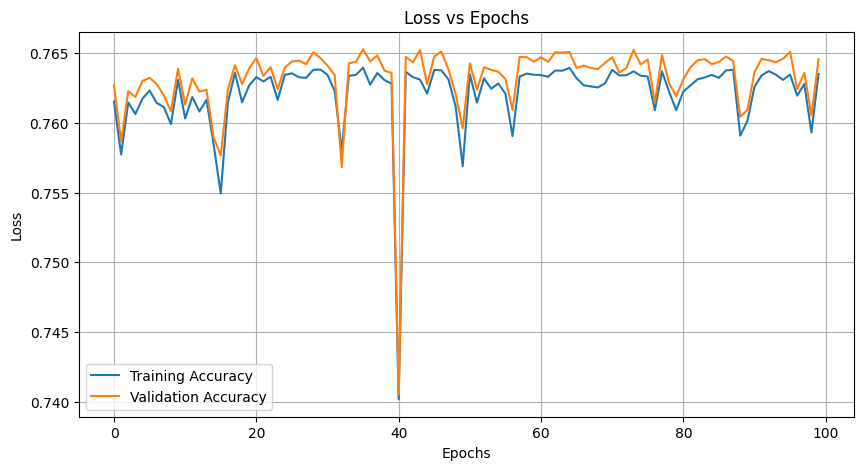

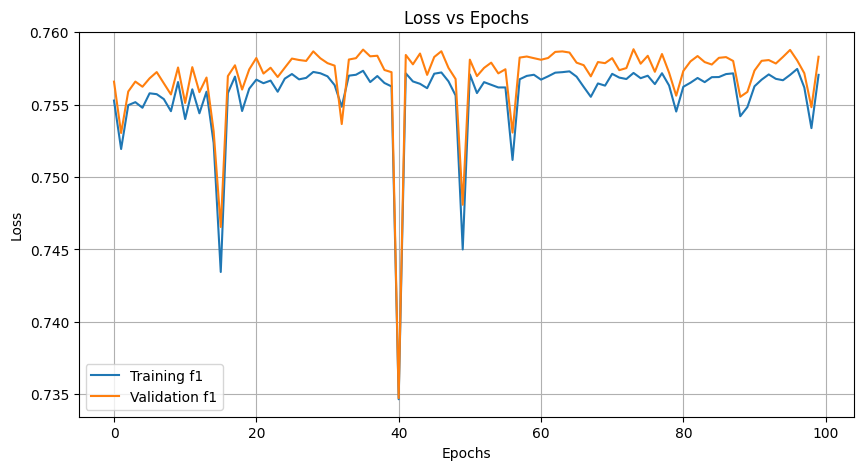

Final Train Accuracy: 0.7635, Final Train F1: 0.7571
Final Validation Accuracy: 0.7646, Final Validation F1: 0.7583


In [34]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_f1_list, label='Training f1')
plt.plot(val_f1_list, label='Validation f1')
plt.title('F1 vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()
plt.grid()
plt.show()

print(f"Final Train Accuracy: {train_acc_list[-1]:.4f}, Final Train F1: {train_f1_list[-1]:.4f}")
print(f'Final Validation Accuracy: {val_acc_list[-1]:.4f}, Final Validation F1: {val_f1_list[-1]:.4f}')

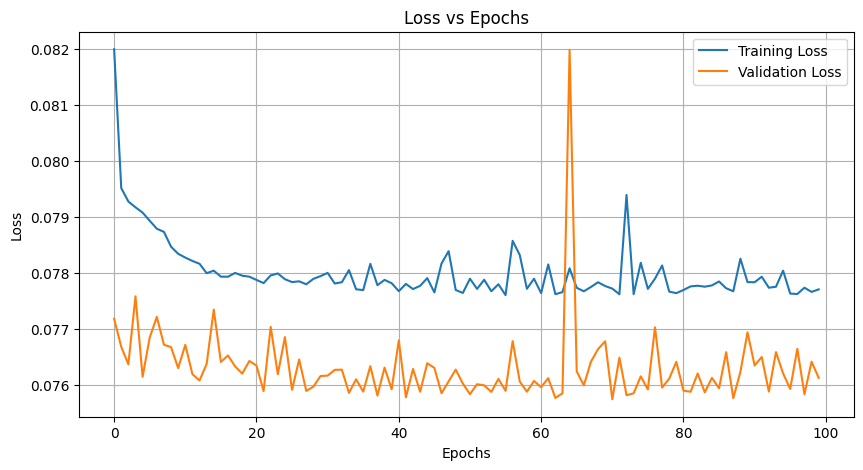

In [35]:

plt.figure(figsize=(10, 5))
plt.plot(train_loss_avg, label='Training Loss')
plt.plot(validation_loss_avg, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

[]

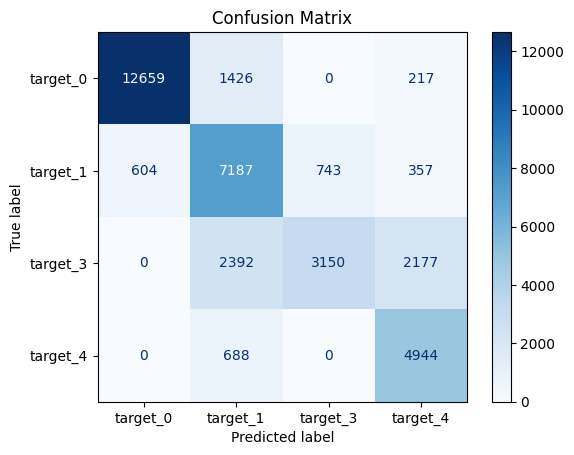

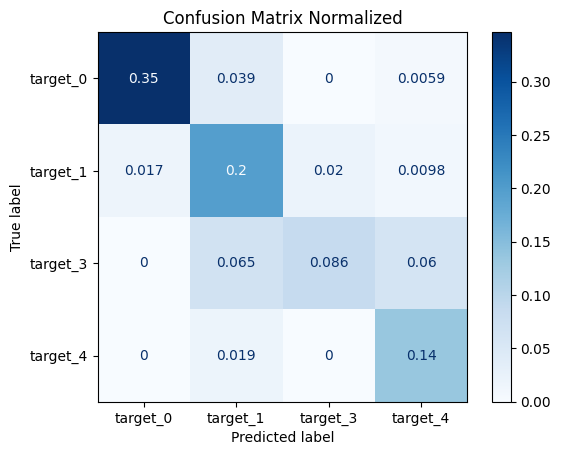

In [41]:
# matriz de confusion
from sklearn.metrics import ConfusionMatrixDisplay

model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in DataLoader(val_data, batch_size=BATCH_SIZE):
        inputs, labels = inputs.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(inputs)
            
        # Get predicted class (argmax over output probabilities)
        _, preds = torch.max(outputs, dim=1)
            
        # convert target to index
        label_classes = torch.argmax(labels, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label_classes.cpu().numpy())

ConfusionMatrixDisplay.from_predictions(y_true=all_labels, y_pred=all_preds, 
                                        display_labels=target_cols, 
                                        cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.plot()

ConfusionMatrixDisplay.from_predictions(y_true=all_labels, y_pred=all_preds, 
                                        display_labels=target_cols,
                                        normalize='all', 
                                        cmap=plt.cm.Blues)
plt.title('Confusion Matrix Normalized')
plt.plot()

### Conclusiones

Se observa que el modelo obten no logra alcanzar las metricas pedidas en el enunciado difiriendo con el accuracy pedido en un pequenio porcentaje. Los porcentajes de drop out y tamanios de capas fully connected se eligieron de manera heuristica tratando de maximizar las metricas de accuracy y f1. Como se vio durante las clases teoricas es muy dificil lograr una generalizacion adecuada sin embeddings cuando hay variables con mucha cardinalidad y eso es lo que se ve reflejado en las curvas de loss en funcion de las epochs y las matrices de confusion.

### 2c) Modelo de deep leaning con embeddings (2 puntos)
Entrenar un modelo de deep learning usando Pytorch que utilice **2 capas de embeddings**, una para los productos y otra para los usuarios. Graficar las evoluciones por época de la función de costo y de métricas como el accuracy y el f1 score para train y test. Mostrar una matriz de confusión absoluta y otra normalizada por fila. Explicar el proceso de iteracion utilizado para conseguir los resultados y justificar los resultados obtenidos. Justificar la cantidad de dimensiones usada para los embeddings. **Comparar contra el modelo sin embeddings** y explicar el porqué de los resultados.

Pueden usarse herramientas de regularización y prueba de hiperpametros para conseguir mejores resultados.

Un resultado aceptable sería al menos un 90% de accuracy y f1 score para el set de validation.

In [43]:
# dataset con embeddings
import pandas as pd
dataset_df = pd.read_csv('dataset_compras.csv')

# descartamos las categorias que no son relevantes y la columna target como se vio en el analisis 
# previo pero conservando la columna de User_ID.
dataset_df.drop(
    columns=['Product_Subcategory_2', 
             'Product_Subcategory_1',
             'Purchase',
             'Product_ID'], inplace=True)

dataset_df.head()

,User_ID,Age,Gender,Marital_Status,City_Category,Stay_In_Current_City_Years,Product_Category
0,1044096,46-50,F,1,B,1,10
1,1071818,36-45,M,0,A,3,11
2,1022986,36-45,M,1,A,5+,4
3,1094684,36-45,M,1,A,1,16
4,1004157,46-50,M,1,A,5+,3


In [44]:
# Reemplazamos los valores de la columna User_ID y Product Category por un 
# indice necesario para aplicar embeddings

product2id = {cat: idx for idx, cat in enumerate(dataset_df['Product_Category'].unique())}
user2id = {user: idx for idx, user in enumerate(dataset_df['User_ID'].unique())}

dataset_df['Product_Category'] = dataset_df['Product_Category'].map(product2id).astype('int64')
dataset_df['User_ID'] = dataset_df['User_ID'].map(user2id).astype('int64')

# aplico one hot a las columnas categóricas restantes
cols = [
    'Age', 'Gender', 
    'Marital_Status', 
    'City_Category', 
    'Stay_In_Current_City_Years']
dataset_df = pd.get_dummies(
    dataset_df, columns=cols, drop_first=True)

dataset_df.head()

,User_ID,Product_Category,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Gender_M,Marital_Status_1,City_Category_B,City_Category_C,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4,Stay_In_Current_City_Years_5+
0,0,0,False,False,False,True,False,False,False,True,True,False,False,False,False,False
1,1,1,False,False,True,False,False,False,True,False,False,False,False,True,False,False
2,2,2,False,False,True,False,False,False,True,True,False,False,False,False,False,True
3,3,3,False,False,True,False,False,False,True,True,False,False,False,False,False,False
4,4,4,False,False,False,True,False,False,True,True,False,False,False,False,False,True


In [45]:
dataset_np = dataset_df.to_numpy().astype(np.float32)
# Definimos las columnas de target
USER_ID_COL = 0
PRODUCT_CATEGORY_COL = 1


In [46]:
from typing import Dict, List, Union, Literal


# Arquitectura del modelo con embeddings
class EmbeddNet(torch.nn.Module):

  def __init__(
      self, 
      user2id: Dict[str, int],
      product2id: Dict[str, int],
      input_features: int = 36,
      dense_layers: List[int] = [50],  # List of layer sizes
      product_embedding_dim: int = 4,
      user_embedding_dim: int = 4,
      n_classes: int = 4,
      dropout_rates: Union[float, List[float]] = 0.1,
      activation: Literal['relu', 'gelu', 'leaky_relu', 'selu', 'silu'] = "gelu",):
    # Defino la arquitectura de la red
    super().__init__()
    
    # embedding layers
    self.product_embedding = nn.Embedding(
      num_embeddings=len(product2id), embedding_dim=product_embedding_dim)
    self.user_embedding = nn.Embedding(
      num_embeddings=len(user2id), embedding_dim=user_embedding_dim)

    self.input_dim = input_features + product_embedding_dim + user_embedding_dim

    in_features = self.input_dim

    self.activation = self._get_activation(activation)
    # Process dropout rates
    if isinstance(dropout_rates, float):
      self.dropout_rates = [dropout_rates] * len(dense_layers)
    else:
      if len(dropout_rates) != len(dense_layers):
        raise ValueError("dropout_rates must match length of dense_layers")
      self.dropout_rates = dropout_rates

    # Create dense blocks
    self.dense_blocks = nn.ModuleList()
    for i, out_features in enumerate(dense_layers):
      block = nn.ModuleDict()
            
      # Linear layer
      block['linear'] = nn.Linear(in_features, out_features)
            
      # Dropout
      block['dropout'] = nn.Dropout(self.dropout_rates[i])   
      self.dense_blocks.append(block)
      in_features = out_features
        
    # Final output layer
    self.output_layer = nn.Linear(in_features, n_classes)

  def _get_activation(self, activation: str) -> nn.Module:
    activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'leaky_relu': nn.LeakyReLU(),
            'selu': nn.SELU(),
            'silu': nn.SiLU()
        }
    return activations.get(activation.lower(), nn.GELU())

  def forward(self, input):

    # process embedding blocks
    # 0 USER_ID
    # 1 PRODUCT_CATEGORY
    emb_products = self.product_embedding(input[:, 1].long())
    emb_users = self.user_embedding(input[:, 0].long())

    x = torch.cat(
        [input[:,2:], emb_products, emb_users], dim=1)

    # Process through dense blocks
    for block in self.dense_blocks:
      x = block['linear'](x)        
      x = self.activation(x)
      x = block['dropout'](x)
        
    # Final output
    x = self.output_layer(x)
    return x

In [47]:
ebd_dataset = MyDataset(x=dataset_np, y=target)

# split in val and train
val_perc = 0.2
train_data, val_data = torch.utils.data.random_split(
    ebd_dataset, [1 - val_perc, val_perc])
print(f'Train samples: {len(train_data)}\nTest samples: {len(val_data)}')

Train samples: 146177
Test samples: 36544


In [48]:
model_ebd = EmbeddNet(
    user2id=user2id,
    product2id=product2id,
    product_embedding_dim=4,
    user_embedding_dim=16,
    input_features=dataset_df.shape[1] - 2, # restamos columnas que usan embeddings
    n_classes=target.shape[1],
    dropout_rates=[0.3, 0.2, 0.1, 0.1],
    dense_layers=[256, 128, 64, 32])
summary(model_ebd)

Layer (type:depth-idx)                   Param #
EmbeddNet                                --
├─Embedding: 1-1                         80
├─Embedding: 1-2                         118,912
├─GELU: 1-3                              --
├─ModuleList: 1-4                        --
│    └─ModuleDict: 2-1                   --
│    │    └─Linear: 3-1                  8,960
│    │    └─Dropout: 3-2                 --
│    └─ModuleDict: 2-2                   --
│    │    └─Linear: 3-3                  32,896
│    │    └─Dropout: 3-4                 --
│    └─ModuleDict: 2-3                   --
│    │    └─Linear: 3-5                  8,256
│    │    └─Dropout: 3-6                 --
│    └─ModuleDict: 2-4                   --
│    │    └─Linear: 3-7                  2,080
│    │    └─Dropout: 3-8                 --
├─Linear: 1-5                            132
Total params: 171,316
Trainable params: 171,316
Non-trainable params: 0

In [49]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# device = "mps" if torch.backends.mps.is_available() else "cpu"

model_ebd.to(device)
print(f'running on device: {device}')

# Loss & optimizer
loss = nn.MSELoss()
optimizer = torch.optim.AdamW(model_ebd.parameters(), lr=5e-3)

# loss = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(
#     params=model_ebd.parameters(), lr=0.005)

EPOCHS = 100
BATCH_SIZE = 64


# Creamos un DataLoader para iterar sobre el dataset
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

running on device: cuda:0


In [50]:
# training loop

from tqdm import tqdm

train_loss_avg = list()
validation_loss_avg = list()

train_acc_list = list()
train_f1_list = list()
val_acc_list = list()
val_f1_list = list()

for epoch in range(EPOCHS):
    model_ebd.train()  # Set the model to training mode
    train_loss_avg.append(0)
    num_batches = 0
    
    for inputs, targets in tqdm(train_loader):

        inputs, targets = inputs.to(device), targets.to(device)  # Move to device

        optimizer.zero_grad()  # Clear gradients
        outputs = model_ebd(inputs)  # Forward pass
        loss_value = loss(outputs, targets)  # Compute loss
        loss_value.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        train_loss_avg[-1] += loss_value.item()
        num_batches += 1   
    train_loss_avg[-1] /= num_batches

    # metrics computation

    # train
    train_acc, train_f1 = compute_metrics(model_ebd, train_loader, device)
    # validation
    val_acc, val_f1 = compute_metrics(
        model_ebd, val_loader, device)
    
    # append per epoch data for plotting
    train_acc_list.append(train_acc)
    train_f1_list.append(train_f1)
    val_acc_list.append(val_acc)
    val_f1_list.append(val_f1)

    # Validation loss
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to compute gradients for validation
        num_batches = 0
        validation_loss_avg.append(0)

        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_ebd(inputs)
            validation_loss_avg[-1] += loss(outputs, targets).item()
            num_batches += 1
        validation_loss_avg[-1] /= num_batches
    print(f"Epoch {epoch+1}, Train loss: {train_loss_avg[-1]:.4f} Val Loss: {validation_loss_avg[-1]:.4f}")
    print(f"Train Acc: {train_acc:.4f} Train F1: {train_f1:.4f} Val Acc: {val_acc:.4f} Val F1: {val_f1:.4f}")

100%|██████████| 2285/2285 [00:03<00:00, 629.21it/s]


Epoch 1, Train loss: 0.0837 Val Loss: 0.0774
Train Acc: 0.7598 Train F1: 0.7547 Val Acc: 0.7583 Val F1: 0.7534


100%|██████████| 2285/2285 [00:03<00:00, 655.20it/s]


Epoch 2, Train loss: 0.0797 Val Loss: 0.0774
Train Acc: 0.7598 Train F1: 0.7547 Val Acc: 0.7583 Val F1: 0.7534


100%|██████████| 2285/2285 [00:03<00:00, 676.73it/s]


Epoch 3, Train loss: 0.0798 Val Loss: 0.0777
Train Acc: 0.7601 Train F1: 0.7559 Val Acc: 0.7573 Val F1: 0.7531


100%|██████████| 2285/2285 [00:03<00:00, 681.24it/s]


Epoch 4, Train loss: 0.0797 Val Loss: 0.0771
Train Acc: 0.7598 Train F1: 0.7548 Val Acc: 0.7583 Val F1: 0.7534


100%|██████████| 2285/2285 [00:03<00:00, 715.61it/s]


Epoch 5, Train loss: 0.0798 Val Loss: 0.0784
Train Acc: 0.7590 Train F1: 0.7556 Val Acc: 0.7563 Val F1: 0.7530


100%|██████████| 2285/2285 [00:03<00:00, 691.12it/s]


Epoch 6, Train loss: 0.0803 Val Loss: 0.0771
Train Acc: 0.7601 Train F1: 0.7553 Val Acc: 0.7580 Val F1: 0.7532


100%|██████████| 2285/2285 [00:03<00:00, 693.49it/s]


Epoch 7, Train loss: 0.0791 Val Loss: 0.0779
Train Acc: 0.7537 Train F1: 0.7451 Val Acc: 0.7496 Val F1: 0.7411


100%|██████████| 2285/2285 [00:03<00:00, 695.25it/s]


Epoch 8, Train loss: 0.0788 Val Loss: 0.0776
Train Acc: 0.7598 Train F1: 0.7548 Val Acc: 0.7582 Val F1: 0.7533


100%|██████████| 2285/2285 [00:03<00:00, 694.06it/s]


Epoch 9, Train loss: 0.0853 Val Loss: 0.0784
Train Acc: 0.7612 Train F1: 0.7571 Val Acc: 0.7566 Val F1: 0.7522


100%|██████████| 2285/2285 [00:03<00:00, 687.46it/s]


Epoch 10, Train loss: 0.0785 Val Loss: 0.0784
Train Acc: 0.7738 Train F1: 0.7744 Val Acc: 0.7506 Val F1: 0.7498


100%|██████████| 2285/2285 [00:03<00:00, 697.64it/s]


Epoch 11, Train loss: 0.0766 Val Loss: 0.0781
Train Acc: 0.7704 Train F1: 0.7692 Val Acc: 0.7553 Val F1: 0.7532


100%|██████████| 2285/2285 [00:03<00:00, 709.70it/s]


Epoch 12, Train loss: 0.0757 Val Loss: 0.0796
Train Acc: 0.7774 Train F1: 0.7803 Val Acc: 0.7424 Val F1: 0.7452


100%|██████████| 2285/2285 [00:03<00:00, 692.12it/s]


Epoch 13, Train loss: 0.0749 Val Loss: 0.0837
Train Acc: 0.7829 Train F1: 0.7866 Val Acc: 0.7344 Val F1: 0.7385


100%|██████████| 2285/2285 [00:03<00:00, 695.81it/s]


Epoch 14, Train loss: 0.0740 Val Loss: 0.0811
Train Acc: 0.7850 Train F1: 0.7882 Val Acc: 0.7331 Val F1: 0.7360


100%|██████████| 2285/2285 [00:03<00:00, 697.57it/s]


Epoch 15, Train loss: 0.0748 Val Loss: 0.0800
Train Acc: 0.7836 Train F1: 0.7867 Val Acc: 0.7413 Val F1: 0.7443


100%|██████████| 2285/2285 [00:03<00:00, 674.03it/s]


Epoch 16, Train loss: 0.0741 Val Loss: 0.0810
Train Acc: 0.7857 Train F1: 0.7893 Val Acc: 0.7333 Val F1: 0.7374


100%|██████████| 2285/2285 [00:03<00:00, 673.32it/s]


Epoch 17, Train loss: 0.0742 Val Loss: 0.0808
Train Acc: 0.7876 Train F1: 0.7905 Val Acc: 0.7369 Val F1: 0.7394


100%|██████████| 2285/2285 [00:03<00:00, 717.20it/s]


Epoch 18, Train loss: 0.0748 Val Loss: 0.0820
Train Acc: 0.7865 Train F1: 0.7895 Val Acc: 0.7287 Val F1: 0.7319


100%|██████████| 2285/2285 [00:03<00:00, 697.12it/s]


Epoch 19, Train loss: 0.0747 Val Loss: 0.0814
Train Acc: 0.7864 Train F1: 0.7894 Val Acc: 0.7397 Val F1: 0.7425


100%|██████████| 2285/2285 [00:03<00:00, 706.61it/s]


Epoch 20, Train loss: 0.0727 Val Loss: 0.0812
Train Acc: 0.7882 Train F1: 0.7908 Val Acc: 0.7303 Val F1: 0.7316


100%|██████████| 2285/2285 [00:03<00:00, 702.98it/s]


Epoch 21, Train loss: 0.2104 Val Loss: 0.1531
Train Acc: 0.7803 Train F1: 0.7819 Val Acc: 0.7450 Val F1: 0.7460


100%|██████████| 2285/2285 [00:03<00:00, 707.20it/s]


Epoch 22, Train loss: 0.1353 Val Loss: 0.0818
Train Acc: 0.7856 Train F1: 0.7893 Val Acc: 0.7301 Val F1: 0.7347


100%|██████████| 2285/2285 [00:03<00:00, 733.96it/s]


Epoch 23, Train loss: 0.0748 Val Loss: 0.0811
Train Acc: 0.7892 Train F1: 0.7925 Val Acc: 0.7284 Val F1: 0.7315


100%|██████████| 2285/2285 [00:03<00:00, 715.45it/s]


Epoch 24, Train loss: 0.0735 Val Loss: 0.0835
Train Acc: 0.7907 Train F1: 0.7942 Val Acc: 0.7297 Val F1: 0.7331


100%|██████████| 2285/2285 [00:03<00:00, 704.77it/s]


Epoch 25, Train loss: 0.0727 Val Loss: 0.0816
Train Acc: 0.7893 Train F1: 0.7929 Val Acc: 0.7353 Val F1: 0.7389


100%|██████████| 2285/2285 [00:03<00:00, 710.95it/s]


Epoch 26, Train loss: 0.0724 Val Loss: 0.0817
Train Acc: 0.7806 Train F1: 0.7830 Val Acc: 0.7451 Val F1: 0.7442


100%|██████████| 2285/2285 [00:03<00:00, 702.18it/s]


Epoch 27, Train loss: 0.0727 Val Loss: 0.0832
Train Acc: 0.7793 Train F1: 0.7798 Val Acc: 0.7392 Val F1: 0.7393


100%|██████████| 2285/2285 [00:03<00:00, 697.49it/s]


Epoch 28, Train loss: 0.0720 Val Loss: 0.0838
Train Acc: 0.7899 Train F1: 0.7925 Val Acc: 0.7323 Val F1: 0.7359


100%|██████████| 2285/2285 [00:03<00:00, 710.76it/s]


Epoch 29, Train loss: 0.0720 Val Loss: 0.0849
Train Acc: 0.7858 Train F1: 0.7880 Val Acc: 0.7140 Val F1: 0.7157


100%|██████████| 2285/2285 [00:03<00:00, 704.69it/s]


Epoch 30, Train loss: 0.0864 Val Loss: 0.0821
Train Acc: 0.7893 Train F1: 0.7922 Val Acc: 0.7324 Val F1: 0.7359


100%|██████████| 2285/2285 [00:03<00:00, 720.63it/s]


Epoch 31, Train loss: 0.0734 Val Loss: 0.0836
Train Acc: 0.7937 Train F1: 0.7975 Val Acc: 0.7303 Val F1: 0.7343


100%|██████████| 2285/2285 [00:03<00:00, 708.38it/s]


Epoch 32, Train loss: 0.0715 Val Loss: 0.0822
Train Acc: 0.7915 Train F1: 0.7944 Val Acc: 0.7245 Val F1: 0.7254


100%|██████████| 2285/2285 [00:03<00:00, 702.11it/s]


Epoch 33, Train loss: 0.0718 Val Loss: 0.0824
Train Acc: 0.7908 Train F1: 0.7946 Val Acc: 0.7288 Val F1: 0.7336


100%|██████████| 2285/2285 [00:03<00:00, 681.95it/s]


Epoch 34, Train loss: 0.4948 Val Loss: 0.0830
Train Acc: 0.7778 Train F1: 0.7796 Val Acc: 0.7446 Val F1: 0.7457


100%|██████████| 2285/2285 [00:03<00:00, 659.23it/s]


Epoch 35, Train loss: 0.0810 Val Loss: 0.0835
Train Acc: 0.7887 Train F1: 0.7922 Val Acc: 0.7337 Val F1: 0.7376


100%|██████████| 2285/2285 [00:03<00:00, 707.84it/s]


Epoch 36, Train loss: 0.0749 Val Loss: 0.0812
Train Acc: 0.7814 Train F1: 0.7816 Val Acc: 0.7474 Val F1: 0.7467


100%|██████████| 2285/2285 [00:03<00:00, 706.29it/s]


Epoch 37, Train loss: 0.0732 Val Loss: 0.0837
Train Acc: 0.7935 Train F1: 0.7973 Val Acc: 0.7288 Val F1: 0.7330


100%|██████████| 2285/2285 [00:03<00:00, 696.73it/s]


Epoch 38, Train loss: 0.0721 Val Loss: 0.0833
Train Acc: 0.7814 Train F1: 0.7828 Val Acc: 0.7453 Val F1: 0.7422


100%|██████████| 2285/2285 [00:03<00:00, 711.02it/s]


Epoch 39, Train loss: 0.0715 Val Loss: 0.0847
Train Acc: 0.7979 Train F1: 0.7998 Val Acc: 0.7239 Val F1: 0.7258


100%|██████████| 2285/2285 [00:03<00:00, 710.79it/s]


Epoch 40, Train loss: 0.1049 Val Loss: 0.1060
Train Acc: 0.7630 Train F1: 0.7646 Val Acc: 0.7204 Val F1: 0.7226


100%|██████████| 2285/2285 [00:03<00:00, 713.09it/s]


Epoch 41, Train loss: 0.0812 Val Loss: 0.0844
Train Acc: 0.8006 Train F1: 0.8022 Val Acc: 0.7323 Val F1: 0.7335


100%|██████████| 2285/2285 [00:03<00:00, 705.87it/s]


Epoch 42, Train loss: 0.0719 Val Loss: 0.0839
Train Acc: 0.8013 Train F1: 0.8028 Val Acc: 0.7360 Val F1: 0.7364


100%|██████████| 2285/2285 [00:03<00:00, 702.85it/s]


Epoch 43, Train loss: 0.0702 Val Loss: 0.0829
Train Acc: 0.7999 Train F1: 0.8011 Val Acc: 0.7325 Val F1: 0.7323


100%|██████████| 2285/2285 [00:03<00:00, 694.14it/s]


Epoch 44, Train loss: 0.0775 Val Loss: 0.0829
Train Acc: 0.8009 Train F1: 0.8018 Val Acc: 0.7363 Val F1: 0.7355


100%|██████████| 2285/2285 [00:03<00:00, 703.17it/s]


Epoch 45, Train loss: 0.0716 Val Loss: 0.0883
Train Acc: 0.8050 Train F1: 0.8067 Val Acc: 0.7218 Val F1: 0.7241


100%|██████████| 2285/2285 [00:03<00:00, 705.31it/s]


Epoch 46, Train loss: 0.0694 Val Loss: 0.0861
Train Acc: 0.8036 Train F1: 0.8054 Val Acc: 0.7357 Val F1: 0.7373


100%|██████████| 2285/2285 [00:03<00:00, 701.47it/s]


Epoch 47, Train loss: 0.0689 Val Loss: 0.0859
Train Acc: 0.8038 Train F1: 0.8034 Val Acc: 0.7327 Val F1: 0.7301


100%|██████████| 2285/2285 [00:03<00:00, 706.40it/s]


Epoch 48, Train loss: 0.0784 Val Loss: 0.0851
Train Acc: 0.8014 Train F1: 0.8024 Val Acc: 0.7351 Val F1: 0.7357


100%|██████████| 2285/2285 [00:03<00:00, 713.04it/s]


Epoch 49, Train loss: 0.0863 Val Loss: 0.0865
Train Acc: 0.8011 Train F1: 0.8033 Val Acc: 0.7267 Val F1: 0.7294


100%|██████████| 2285/2285 [00:03<00:00, 720.11it/s]


Epoch 50, Train loss: 0.0725 Val Loss: 0.0850
Train Acc: 0.8036 Train F1: 0.8052 Val Acc: 0.7281 Val F1: 0.7302


100%|██████████| 2285/2285 [00:03<00:00, 705.35it/s]


Epoch 51, Train loss: 0.0699 Val Loss: 0.0868
Train Acc: 0.8091 Train F1: 0.8100 Val Acc: 0.7250 Val F1: 0.7251


100%|██████████| 2285/2285 [00:03<00:00, 722.57it/s]


Epoch 52, Train loss: 0.0690 Val Loss: 0.0865
Train Acc: 0.8073 Train F1: 0.8077 Val Acc: 0.7293 Val F1: 0.7280


100%|██████████| 2285/2285 [00:03<00:00, 694.29it/s]


Epoch 53, Train loss: 0.0875 Val Loss: 0.0869
Train Acc: 0.7854 Train F1: 0.7826 Val Acc: 0.7407 Val F1: 0.7361


100%|██████████| 2285/2285 [00:03<00:00, 697.83it/s]


Epoch 54, Train loss: 0.0752 Val Loss: 0.0871
Train Acc: 0.8053 Train F1: 0.8059 Val Acc: 0.7332 Val F1: 0.7329


100%|██████████| 2285/2285 [00:03<00:00, 706.14it/s]


Epoch 55, Train loss: 0.0697 Val Loss: 0.0866
Train Acc: 0.8090 Train F1: 0.8094 Val Acc: 0.7301 Val F1: 0.7293


100%|██████████| 2285/2285 [00:03<00:00, 699.91it/s]


Epoch 56, Train loss: 0.0688 Val Loss: 0.0861
Train Acc: 0.8067 Train F1: 0.8066 Val Acc: 0.7298 Val F1: 0.7285


100%|██████████| 2285/2285 [00:03<00:00, 695.84it/s]


Epoch 57, Train loss: 0.0804 Val Loss: 0.0837
Train Acc: 0.7995 Train F1: 0.7989 Val Acc: 0.7418 Val F1: 0.7399


100%|██████████| 2285/2285 [00:03<00:00, 700.04it/s]


Epoch 58, Train loss: 0.1650 Val Loss: 0.0853
Train Acc: 0.8014 Train F1: 0.8013 Val Acc: 0.7385 Val F1: 0.7372


100%|██████████| 2285/2285 [00:03<00:00, 716.30it/s]


Epoch 59, Train loss: 0.0704 Val Loss: 0.0880
Train Acc: 0.8074 Train F1: 0.8073 Val Acc: 0.7340 Val F1: 0.7329


100%|██████████| 2285/2285 [00:03<00:00, 703.17it/s]


Epoch 60, Train loss: 0.0687 Val Loss: 0.0859
Train Acc: 0.8037 Train F1: 0.8026 Val Acc: 0.7383 Val F1: 0.7355


100%|██████████| 2285/2285 [00:03<00:00, 703.70it/s]


Epoch 61, Train loss: 0.0681 Val Loss: 0.0870
Train Acc: 0.8033 Train F1: 0.8032 Val Acc: 0.7433 Val F1: 0.7399


100%|██████████| 2285/2285 [00:03<00:00, 703.38it/s]


Epoch 62, Train loss: 0.0686 Val Loss: 0.0866
Train Acc: 0.8035 Train F1: 0.8028 Val Acc: 0.7350 Val F1: 0.7330


100%|██████████| 2285/2285 [00:03<00:00, 704.91it/s]


Epoch 63, Train loss: 0.0680 Val Loss: 0.0893
Train Acc: 0.8135 Train F1: 0.8141 Val Acc: 0.7344 Val F1: 0.7320


100%|██████████| 2285/2285 [00:03<00:00, 705.20it/s]


Epoch 64, Train loss: 1.2016 Val Loss: 0.0849
Train Acc: 0.8086 Train F1: 0.8080 Val Acc: 0.7377 Val F1: 0.7354


100%|██████████| 2285/2285 [00:03<00:00, 680.73it/s]


Epoch 65, Train loss: 0.0726 Val Loss: 0.0849
Train Acc: 0.8068 Train F1: 0.8073 Val Acc: 0.7359 Val F1: 0.7357


100%|██████████| 2285/2285 [00:03<00:00, 655.27it/s]


Epoch 66, Train loss: 0.0695 Val Loss: 0.0865
Train Acc: 0.8227 Train F1: 0.8221 Val Acc: 0.7324 Val F1: 0.7309


100%|██████████| 2285/2285 [00:03<00:00, 665.02it/s]


Epoch 67, Train loss: 0.0681 Val Loss: 0.0869
Train Acc: 0.8186 Train F1: 0.8156 Val Acc: 0.7427 Val F1: 0.7367


100%|██████████| 2285/2285 [00:03<00:00, 694.67it/s]


Epoch 68, Train loss: 0.0670 Val Loss: 0.0839
Train Acc: 0.8168 Train F1: 0.8151 Val Acc: 0.7430 Val F1: 0.7380


100%|██████████| 2285/2285 [00:03<00:00, 696.97it/s]


Epoch 69, Train loss: 0.0824 Val Loss: 0.0856
Train Acc: 0.8160 Train F1: 0.8138 Val Acc: 0.7459 Val F1: 0.7409


100%|██████████| 2285/2285 [00:03<00:00, 698.55it/s]


Epoch 70, Train loss: 0.0691 Val Loss: 0.0866
Train Acc: 0.8233 Train F1: 0.8228 Val Acc: 0.7342 Val F1: 0.7337


100%|██████████| 2285/2285 [00:03<00:00, 692.33it/s]


Epoch 71, Train loss: 0.0670 Val Loss: 0.0870
Train Acc: 0.8269 Train F1: 0.8253 Val Acc: 0.7430 Val F1: 0.7401


100%|██████████| 2285/2285 [00:03<00:00, 659.19it/s]


Epoch 72, Train loss: 0.0662 Val Loss: 0.0876
Train Acc: 0.8267 Train F1: 0.8261 Val Acc: 0.7380 Val F1: 0.7361


100%|██████████| 2285/2285 [00:03<00:00, 649.02it/s]


Epoch 73, Train loss: 0.0665 Val Loss: 0.0881
Train Acc: 0.8261 Train F1: 0.8241 Val Acc: 0.7394 Val F1: 0.7354


100%|██████████| 2285/2285 [00:03<00:00, 698.05it/s]


Epoch 74, Train loss: 0.0657 Val Loss: 0.0879
Train Acc: 0.8267 Train F1: 0.8241 Val Acc: 0.7453 Val F1: 0.7420


100%|██████████| 2285/2285 [00:03<00:00, 712.88it/s]


Epoch 75, Train loss: 0.0653 Val Loss: 0.0896
Train Acc: 0.8286 Train F1: 0.8260 Val Acc: 0.7411 Val F1: 0.7377


100%|██████████| 2285/2285 [00:03<00:00, 695.14it/s]


Epoch 76, Train loss: 0.0649 Val Loss: 0.0856
Train Acc: 0.8282 Train F1: 0.8265 Val Acc: 0.7418 Val F1: 0.7394


100%|██████████| 2285/2285 [00:03<00:00, 664.01it/s]


Epoch 77, Train loss: 0.4208 Val Loss: 0.0835
Train Acc: 0.8067 Train F1: 0.8037 Val Acc: 0.7510 Val F1: 0.7472


100%|██████████| 2285/2285 [00:03<00:00, 670.68it/s]


Epoch 78, Train loss: 0.0745 Val Loss: 0.0869
Train Acc: 0.8238 Train F1: 0.8207 Val Acc: 0.7477 Val F1: 0.7436


100%|██████████| 2285/2285 [00:03<00:00, 687.86it/s]


Epoch 79, Train loss: 0.0691 Val Loss: 0.0864
Train Acc: 0.8272 Train F1: 0.8258 Val Acc: 0.7421 Val F1: 0.7401


100%|██████████| 2285/2285 [00:03<00:00, 693.57it/s]


Epoch 80, Train loss: 0.0669 Val Loss: 0.0870
Train Acc: 0.8227 Train F1: 0.8204 Val Acc: 0.7453 Val F1: 0.7412


100%|██████████| 2285/2285 [00:03<00:00, 704.54it/s]


Epoch 81, Train loss: 0.0654 Val Loss: 0.0883
Train Acc: 0.8311 Train F1: 0.8263 Val Acc: 0.7430 Val F1: 0.7365


100%|██████████| 2285/2285 [00:03<00:00, 693.76it/s]


Epoch 82, Train loss: 0.0648 Val Loss: 0.0874
Train Acc: 0.8281 Train F1: 0.8253 Val Acc: 0.7413 Val F1: 0.7364


100%|██████████| 2285/2285 [00:03<00:00, 691.85it/s]


Epoch 83, Train loss: 0.1525 Val Loss: 0.0862
Train Acc: 0.8263 Train F1: 0.8246 Val Acc: 0.7443 Val F1: 0.7414


100%|██████████| 2285/2285 [00:03<00:00, 687.22it/s]


Epoch 84, Train loss: 0.0665 Val Loss: 0.0878
Train Acc: 0.8289 Train F1: 0.8279 Val Acc: 0.7412 Val F1: 0.7394


100%|██████████| 2285/2285 [00:03<00:00, 693.85it/s]


Epoch 85, Train loss: 0.0642 Val Loss: 0.0911
Train Acc: 0.8326 Train F1: 0.8281 Val Acc: 0.7424 Val F1: 0.7357


100%|██████████| 2285/2285 [00:03<00:00, 717.98it/s]


Epoch 86, Train loss: 0.0643 Val Loss: 0.0872
Train Acc: 0.8301 Train F1: 0.8278 Val Acc: 0.7418 Val F1: 0.7386


100%|██████████| 2285/2285 [00:03<00:00, 703.97it/s]


Epoch 87, Train loss: 0.0639 Val Loss: 0.0874
Train Acc: 0.8305 Train F1: 0.8257 Val Acc: 0.7434 Val F1: 0.7361


100%|██████████| 2285/2285 [00:03<00:00, 713.89it/s]


Epoch 88, Train loss: 0.0819 Val Loss: 0.0894
Train Acc: 0.8308 Train F1: 0.8292 Val Acc: 0.7427 Val F1: 0.7400


100%|██████████| 2285/2285 [00:03<00:00, 702.99it/s]


Epoch 89, Train loss: 0.0647 Val Loss: 0.0901
Train Acc: 0.8323 Train F1: 0.8278 Val Acc: 0.7414 Val F1: 0.7341


100%|██████████| 2285/2285 [00:03<00:00, 697.12it/s]


Epoch 90, Train loss: 0.0637 Val Loss: 0.0917
Train Acc: 0.8357 Train F1: 0.8332 Val Acc: 0.7324 Val F1: 0.7281


100%|██████████| 2285/2285 [00:03<00:00, 686.34it/s]


Epoch 91, Train loss: 0.0653 Val Loss: 0.0891
Train Acc: 0.8327 Train F1: 0.8305 Val Acc: 0.7395 Val F1: 0.7356


100%|██████████| 2285/2285 [00:03<00:00, 691.68it/s]


Epoch 92, Train loss: 0.0637 Val Loss: 0.0910
Train Acc: 0.8328 Train F1: 0.8285 Val Acc: 0.7404 Val F1: 0.7339


100%|██████████| 2285/2285 [00:03<00:00, 706.85it/s]


Epoch 93, Train loss: 0.0639 Val Loss: 0.0896
Train Acc: 0.8334 Train F1: 0.8307 Val Acc: 0.7433 Val F1: 0.7391


100%|██████████| 2285/2285 [00:03<00:00, 706.01it/s]


Epoch 94, Train loss: 0.1870 Val Loss: 0.0873
Train Acc: 0.8237 Train F1: 0.8196 Val Acc: 0.7424 Val F1: 0.7365


100%|██████████| 2285/2285 [00:03<00:00, 702.38it/s]


Epoch 95, Train loss: 0.0675 Val Loss: 0.0876
Train Acc: 0.8297 Train F1: 0.8270 Val Acc: 0.7448 Val F1: 0.7412


100%|██████████| 2285/2285 [00:03<00:00, 702.27it/s]


Epoch 96, Train loss: 0.0653 Val Loss: 0.0892
Train Acc: 0.8322 Train F1: 0.8291 Val Acc: 0.7407 Val F1: 0.7351


100%|██████████| 2285/2285 [00:03<00:00, 690.90it/s]


Epoch 97, Train loss: 0.0640 Val Loss: 0.0903
Train Acc: 0.8293 Train F1: 0.8259 Val Acc: 0.7426 Val F1: 0.7374


100%|██████████| 2285/2285 [00:03<00:00, 693.62it/s]


Epoch 98, Train loss: 0.0637 Val Loss: 0.0919
Train Acc: 0.8302 Train F1: 0.8279 Val Acc: 0.7386 Val F1: 0.7338


100%|██████████| 2285/2285 [00:03<00:00, 697.59it/s]


Epoch 99, Train loss: 0.0645 Val Loss: 0.0903
Train Acc: 0.8302 Train F1: 0.8273 Val Acc: 0.7380 Val F1: 0.7329


100%|██████████| 2285/2285 [00:03<00:00, 688.17it/s]


Epoch 100, Train loss: 0.7053 Val Loss: 0.0869
Train Acc: 0.8191 Train F1: 0.8151 Val Acc: 0.7464 Val F1: 0.7398


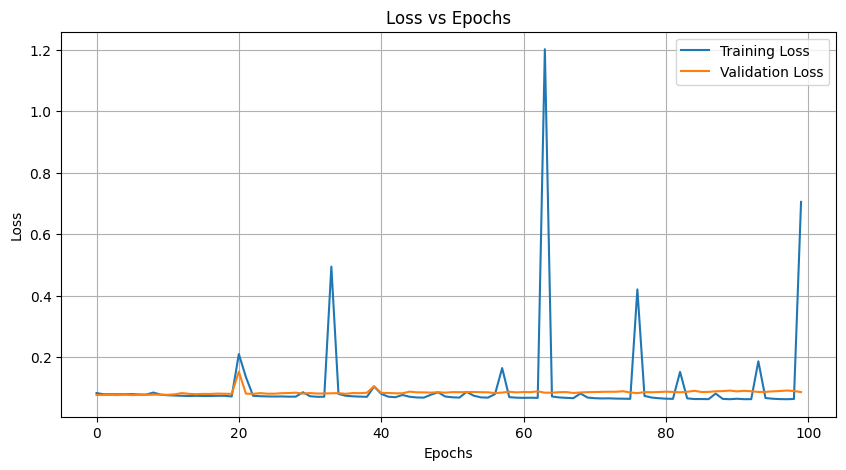

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_avg, label='Training Loss')
plt.plot(validation_loss_avg, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

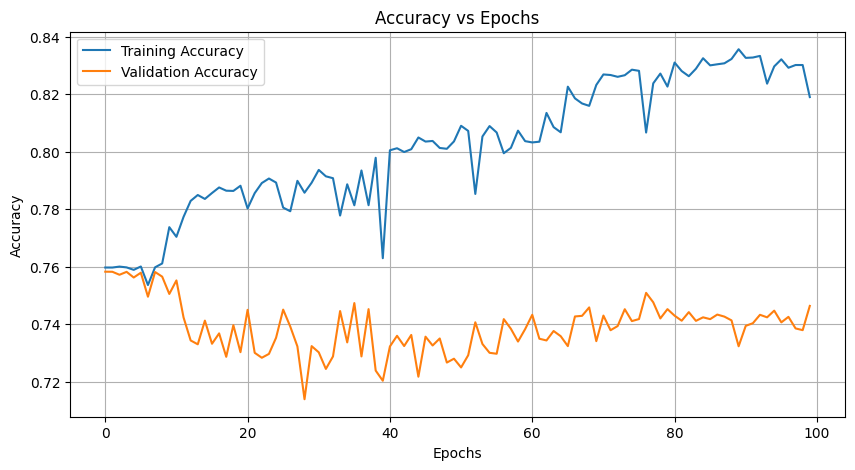

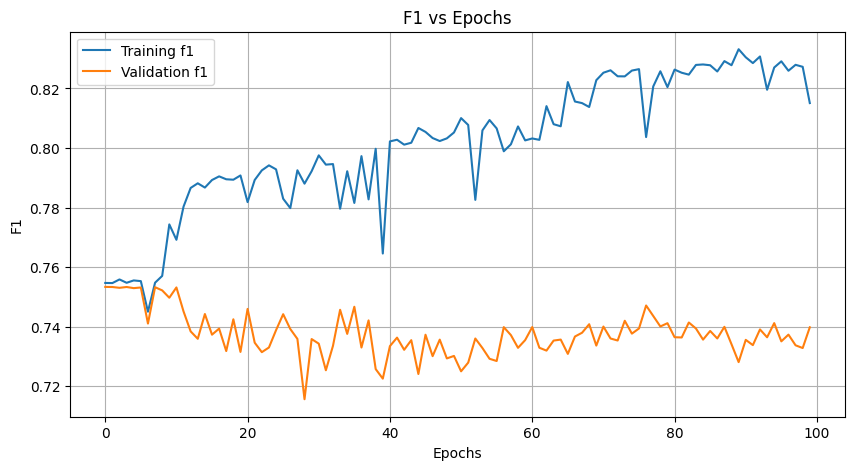

Final Train Accuracy: 0.8191, Final Train F1: 0.8151
Final Validation Accuracy: 0.7464, Final Validation F1: 0.7398


In [52]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_f1_list, label='Training f1')
plt.plot(val_f1_list, label='Validation f1')
plt.title('F1 vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
plt.grid()
plt.show()

print(f"Final Train Accuracy: {train_acc_list[-1]:.4f}, Final Train F1: {train_f1_list[-1]:.4f}")
print(f'Final Validation Accuracy: {val_acc_list[-1]:.4f}, Final Validation F1: {val_f1_list[-1]:.4f}')

[]

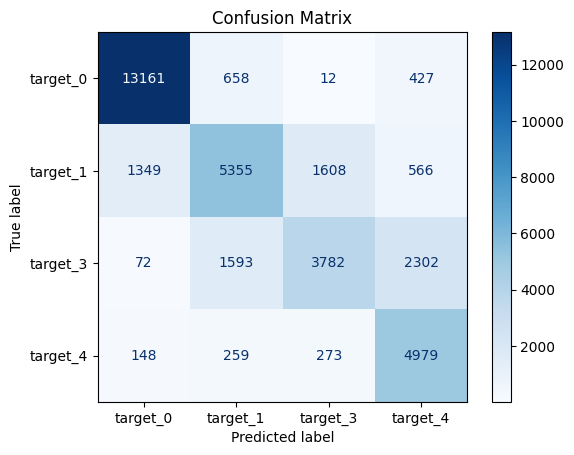

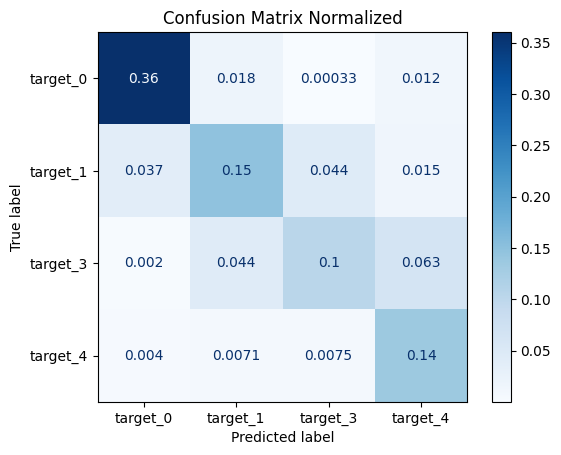

In [53]:
model_ebd.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in DataLoader(val_data, batch_size=BATCH_SIZE):
        inputs, labels = inputs.to(device), labels.to(device)
            
        # Forward pass
        outputs = model_ebd(inputs)
            
        # Get predicted class (argmax over output probabilities)
        _, preds = torch.max(outputs, dim=1)
            
        # convert target to index
        label_classes = torch.argmax(labels, dim=1)

        # Store predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label_classes.cpu().numpy())

ConfusionMatrixDisplay.from_predictions(y_true=all_labels, y_pred=all_preds, 
                                        display_labels=target_cols, 
                                        cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.plot()

ConfusionMatrixDisplay.from_predictions(y_true=all_labels, y_pred=all_preds, 
                                        display_labels=target_cols,
                                        normalize='all', 
                                        cmap=plt.cm.Blues)
plt.title('Confusion Matrix Normalized')
plt.plot()

### Conclusiones

Se observa una mejora frente al modelo anterior. Utilizando embeddings se logra un accuracy del 85% frente a un 75% sin embedding pero aun asi no se logro alcanzar el numero objetivo pedido en el enunciado.



### 2d) Encontrar usuarios similares (1 punto)
Para el modelo del punto 2c) implementar una función que reciba un ID de usuario y sugiera **n** cantidad de usuarios que tuvieron un comportamiento de compras similar. También se debe mostrar el grado o porcentaje de similitud de cada usuario que retorne la función.